In [1]:
save_path = '/Users/maori2/Documents/revision_stuff/All_dataset/sessions_files'
umap_path = '/Users/maori2/Documents/revision_stuff/All_dataset/umap_files'
fig_path = "/Users/maori2/Documents/revision_stuff/new_figures"
umap_path_2save ="/Users/maori2/Documents/revision_stuff/All_dataset/umap_files/new_run"
geom_path = "/Users/maori2/Documents/revision_stuff/All_dataset/geom_files/2save"

import scipy.io as sio
import scipy.stats as sts
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
from scipy import stats
from scipy.stats import mannwhitneyu
from scipy.stats import levene
from scipy.stats import kruskal
import umap.umap_ as umap

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn.axisgrid")
warnings.filterwarnings("ignore", category=FutureWarning, module="statsmodels")
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas")
warnings.filterwarnings("ignore", message="n_jobs value 1 overridden")

import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from scipy.spatial.distance import mahalanobis as mahal
from scipy.spatial.distance import seuclidean, canberra, euclidean, cosine, minkowski
from scipy.linalg import pinvh

from matplotlib.gridspec import GridSpec
import statsmodels.api as sm
from scipy.spatial.distance import cosine

import scipy.io
from scipy.stats import norm
from scipy.signal import convolve
import time
from scipy.stats import ttest_ind
import statsmodels.formula.api as smf

from sklearn import svm
from sklearn.model_selection import cross_val_predict, cross_val_score, LeaveOneOut
#from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from scipy.stats import sem
from sklearn import set_config
from sklearn.model_selection import permutation_test_score

from sklearn.linear_model import LinearRegression

#import umap.umap_ as umap
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

color_set = ["#1a80bb", "#f2c45f", "#b8b8b8", "#FF33FF", "#FFFF33"]

plt.rcParams['axes.grid'] = False        # Disable grid lines globally
plt.rcParams['axes.linewidth'] = 1    # Make axes thicker
plt.rcParams['axes.edgecolor'] = 'black' # Make axes darker


def analyze_behave(Analysis_table):

    Analysis_table_f = Analysis_table[(Analysis_table.correction_trial==0) & (Analysis_table.odor_unpoke_early==0)].reset_index()
    max_unpoke = 5000 #trim the sampling odor windo to 5 sec
    Analysis_table_f.loc[Analysis_table_f.odor_unpoke-Analysis_table_f.odor_poke>max_unpoke,'odor_unpoke']=Analysis_table_f.odor_poke+max_unpoke
    Analysis_table_f.loc[:,'pre_trial'] = Analysis_table_f['light_on'] - 1000

    y = np.array(Analysis_table_f.go_nogo)
    s1 = np.column_stack((Analysis_table_f.odor_ID,Analysis_table_f.odor_ID.shift(1,fill_value=np.nan),Analysis_table_f.odor_ID.shift(2,fill_value=np.nan)))
    cdnm_rule = s1[:,0]!=s1[:,1]
    disc_rule = np.in1d(s1[:,0], [0,1,2,3,4,5,6,7])

    HitRate_cdnm = (y[cdnm_rule==1].astype(bool)==1)
    FaRate_cdnm = (y[cdnm_rule==0].astype(bool)==1)
    HitRate_disc =(y[disc_rule==1].astype(bool)==1)
    FaRate_disc = (y[disc_rule==0].astype(bool)==1)

    correct_cdnm = (np.average(HitRate_cdnm)+(1-np.average(FaRate_cdnm)))/2
    correct_disc = (np.average(HitRate_disc)+(1-np.average(FaRate_disc)))/2

    def calculate_d_prime(hits, false_alarms):
        if hits == 0:
            hits = 0.01
        if false_alarms == 0:
            false_alarms = 0.01
        if hits == 1:
            hits = 1 - 0.01
        if false_alarms == 1:
            false_alarms = 1 - 0.01


        hits = np.array(hits)
        false_alarms = np.array(false_alarms)

        # z-scores
        hitZ = sts.norm.ppf(hits)
        faZ  = sts.norm.ppf(false_alarms)

        # d-prime
        dPrime = hitZ-faZ

        return dPrime

    def find_first_index(Analysis_table_f): # Custom function to find the first index in vehave_crit where Value = 1
        index = (Analysis_table_f['behave_crit'] == 1).idxmax()
        return index if not (index==0 or pd.isna(index)) else 500

    dPrime_cdnm = calculate_d_prime(np.average(HitRate_cdnm), np.average(FaRate_cdnm))
    dPrime_disc = calculate_d_prime(np.average(HitRate_disc), np.average(FaRate_disc))
    tr_to_crit = index

    Analysis_table_mod = Analysis_table_f.copy()

    Analysis_table_mod.loc[:,'cdnm_rule']=cdnm_rule
    Analysis_table_mod.loc[:,'disc_rule']=disc_rule
    Analysis_table_mod.loc[:,'time_to_poke']=Analysis_table_f['odor_poke']-Analysis_table_f['light_on']
    Analysis_table_mod.loc[:,'time_to_unpoke']=Analysis_table_f['odor_unpoke']-Analysis_table_f['odor_poke']
    Analysis_table_mod.loc[:,'time_to_water']=Analysis_table_f['water_poke']-Analysis_table_f['odor_poke']
    Analysis_table_mod.loc[:,'ITI']=Analysis_table_mod['light_on'].diff()
    Analysis_table_mod.loc[:,'odor_before']=s1[:,1]
    Analysis_table_mod.loc[0,'odor_before']=Analysis_table_mod.loc[1,'odor_before'] #puting the same odor on the first trial to avoide nans


    behave_dict = {
        "Analysis_table_mod":Analysis_table_mod,
        "correct_cdnm": correct_cdnm,
        "correct_disc": correct_disc,
        "dPrime_cdnm": dPrime_cdnm,
        "dPrime_disc": dPrime_disc,
        "tr_to_crit": tr_to_crit,
        "HitRate_cdnm": HitRate_cdnm,
        "FaRate_cdnm": FaRate_cdnm,
        "HitRate_disc":HitRate_disc,
        "FaRate_disc": FaRate_disc
    }
    return behave_dict

def calculate_d_prime(hits, false_alarms):
    if hits == 0:
        hits = 0.01
    if false_alarms == 0:
        false_alarms = 0.01
    if hits == 1:
        hits = 1 - 0.01
    if false_alarms == 1:
        false_alarms = 1 - 0.01


    hits = np.array(hits)
    false_alarms = np.array(false_alarms)

    # z-scores
    hitZ = sts.norm.ppf(hits)
    faZ  = sts.norm.ppf(false_alarms)

    # d-prime
    dPrime = hitZ-faZ

    return dPrime

def bin_performance(Analysis_table_f,  bin_num=4):
    y = np.array(Analysis_table_f.go_nogo)
    s1 = np.column_stack((Analysis_table_f.odor_ID,Analysis_table_f.odor_ID.shift(1,fill_value=np.nan),Analysis_table_f.odor_ID.shift(2,fill_value=np.nan)))
    cdnm_rule = s1[:,0]!=s1[:,1]
    disc_rule = np.in1d(s1[:,0], [0,1,2,3,4,5,6,7])

    cdnm_only = (cdnm_rule==1) & (disc_rule==0)
    disc_only = (cdnm_rule==0) & (disc_rule==1)

    HitRate_cdnm = (y[cdnm_rule==1].astype(bool)==1)
    FaRate_cdnm = (y[cdnm_rule==0].astype(bool)==1)
    HitRate_disc =(y[disc_rule==1].astype(bool)==1)
    FaRate_disc = (y[disc_rule==0].astype(bool)==1)

    HitRate_cdnm_only = (y[cdnm_only==1].astype(bool)==1)
    FaRate_cdnm_only =  (y[cdnm_only==0].astype(bool)==1)
    HitRate_disc_only = (y[disc_only==1].astype(bool)==1)
    FaRate_disc_only = (y[disc_only==0].astype(bool)==1)

    correct_cdnm_bin =[]
    correct_disc_bin = []
    dPrime_cdnm_bin =[]
    dPrime_disc_bin = []
    HitRate_cdnm_bin =[]
    FARate_cdnm_bin = []
    HitRate_disc_bin =[]
    FARate_disc_bin = []
    correct_cdnm_only_bin =[]
    correct_disc_only_bin = []

    hist, bin_edges_1 = np.histogram(np.arange(0, len(HitRate_cdnm)), bins=bin_num); bined_day_1 = np.floor(bin_edges_1).astype(int)
    hist, bin_edges_2 = np.histogram(np.arange(0, len(FaRate_cdnm)), bins=bin_num); bined_day_2 = np.floor(bin_edges_2).astype(int)
    hist, bin_edges_3 = np.histogram(np.arange(0, len(HitRate_disc)), bins=bin_num); bined_day_3 = np.floor(bin_edges_3).astype(int)
    hist, bin_edges_4 = np.histogram(np.arange(0, len(FaRate_disc)), bins=bin_num); bined_day_4 = np.floor(bin_edges_4).astype(int)

    hist, bin_edges_5 = np.histogram(np.arange(0, len(HitRate_cdnm_only)), bins=bin_num); bined_day_5 = np.floor(bin_edges_5).astype(int)
    hist, bin_edges_6 = np.histogram(np.arange(0, len(FaRate_cdnm_only)), bins=bin_num); bined_day_6 = np.floor(bin_edges_6).astype(int)
    hist, bin_edges_7 = np.histogram(np.arange(0, len(HitRate_disc_only)), bins=bin_num); bined_day_7 = np.floor(bin_edges_7).astype(int)
    hist, bin_edges_8 = np.histogram(np.arange(0, len(FaRate_disc_only)), bins=bin_num); bined_day_8 = np.floor(bin_edges_8).astype(int)

    for ii in range(len(bined_day_1) - 1):

        #correct_cdnm_bin.append(np.average(raw_correct_cdnm_rule[start_index1:end_index1]))
        #correct_disc_bin.append(np.average(raw_correct_disc_rule[start_index1:end_index1]))
        correct_cdnm_bin.append((np.average(HitRate_cdnm[bined_day_1[ii]:bined_day_1[ii+1]])+(1-np.average(FaRate_cdnm[bined_day_2[ii]:bined_day_2[ii+1]])))/2)
        correct_disc_bin.append((np.average(HitRate_disc[bined_day_3[ii]:bined_day_3[ii+1]])+(1-np.average(FaRate_disc[bined_day_4[ii]:bined_day_4[ii+1]])))/2)

        dPrime_cdnm_bin.append(calculate_d_prime(np.average(HitRate_cdnm[bined_day_1[ii]:bined_day_1[ii+1]]), np.average(FaRate_cdnm[bined_day_2[ii]:bined_day_2[ii+1]])))
        dPrime_disc_bin.append(calculate_d_prime(np.average(HitRate_disc[bined_day_3[ii]:bined_day_3[ii+1]]), np.average(FaRate_disc[bined_day_4[ii]:bined_day_4[ii+1]])))

        HitRate_cdnm_bin.append(np.average(HitRate_cdnm[bined_day_1[ii]:bined_day_1[ii+1]]))
        FARate_cdnm_bin.append(np.average(FaRate_cdnm[bined_day_2[ii]:bined_day_2[ii+1]]))
        HitRate_disc_bin.append(np.average(HitRate_disc[bined_day_3[ii]:bined_day_3[ii+1]]))
        FARate_disc_bin.append(np.average(FaRate_disc[bined_day_4[ii]:bined_day_4[ii+1]]))

        correct_cdnm_only_bin.append((np.average(HitRate_cdnm_only[bined_day_5[ii]:bined_day_5[ii+1]])+(1-np.average(FaRate_cdnm_only[bined_day_6[ii]:bined_day_6[ii+1]])))/2)
        correct_disc_only_bin.append((np.average(HitRate_disc_only[bined_day_7[ii]:bined_day_7[ii+1]])+(1-np.average(FaRate_disc_only[bined_day_8[ii]:bined_day_8[ii+1]])))/2)

    return correct_cdnm_bin,correct_disc_bin,dPrime_cdnm_bin,dPrime_disc_bin,HitRate_cdnm_bin,FARate_cdnm_bin,HitRate_disc_bin,FARate_disc_bin,correct_cdnm_only_bin,correct_disc_only_bin
def running_average_crossing_threshold(Table, Win, T, X):
    # Create logical variable 'A' where 'B' is 'Hit' or 'CR'
    Table['A'] = ((Table['score'] == 'Hit') | (Table['score'] == 'CR')).astype(int)

    # Calculate the running average of the column 'A' with a window size 'Win'
    Table['Running_Avg'] = Table['A'].rolling(window=Win).mean()

    # Determine when the running average crosses the threshold 'T'
    Table['Crossed_Threshold'] = (Table['Running_Avg'] > T).astype(int)

    # Find consecutive crossings of length X
    Table['Consecutive_Crossings'] = Table['Crossed_Threshold'].rolling(window=X).sum()

    # Determine where exactly the threshold is reached in X consecutive rows
    #crossing_points = (Table['Consecutive_Crossings'] >= X) & (Table['Crossed_Threshold'] == 1)
    crossing_points = Table[(Table['Consecutive_Crossings'] >= X) & (Table['Crossed_Threshold'] == 1)]

    # Find the first index where the condition is met
    first_crossing_index = crossing_points.index[0] if not crossing_points.empty else None


    return Table, first_crossing_index
#correct_cdnm_bin,correct_disc_bin,dPrime_cdnm_bin,dPrime_disc_bin,HitRate_cdnm_bin,FARate_cdnm_bin,HitRate_disc_bin,FARate_disc_bin,correct_cdnm_only_bin,correct_disc_only_bin = bin_performance(Analysis_table_f,  bin_num=10)
def divide_intervals(start_times, end_times, num_intervals):
    # Check if the input arrays have the same length
    if len(start_times) != len(end_times):
        raise ValueError("Input arrays must have the same length")

    # Calculate the duration of each interval
    interval_durations = (end_times - start_times) / num_intervals

    # Create a list to store the divided intervals
    divided_intervals = []

    # Iterate through each start and end time pair
    for start, end in zip(start_times, end_times):
        # Calculate the boundaries of each subinterval
        subinterval_boundaries = np.linspace(start, end, num_intervals + 1)

        divided_intervals.append(subinterval_boundaries)

    return divided_intervals

def calc_PETH_equal_bins (Analysis_table, spikeTime , event_start = 'odor_poke' , event_end = 'odor_unpoke' , bin_num = 5):
    start_times = np.array(Analysis_table[event_start])/1000
    end_times = np.array(Analysis_table[event_end])/1000

    time_intervals = divide_intervals(start_times, end_times, bin_num)
    ntrials=len(time_intervals)
    temp1=[]
    for (trial_idx, trial) in enumerate(time_intervals):
        binduration=np.round(np.diff(trial)[0],decimals=2)
        temp2=[]
        for (unit_idx, spikes_unit) in enumerate(spikeTime):
            spikeinds = spikes_unit[np.logical_and((spikes_unit >= trial[0]),(spikes_unit < trial[-1]))]
            spikes_bin =np.histogram(spikeinds,bins = trial)
            temp2.append((1/binduration)*spikes_bin[0])# moving to Hz - 08/15/2024
            #temp2.append(spikes_bin[0])
        temp1.append(np.array(temp2))
    spikes_all = np.array(temp1) # [Trials,units,bins]
    PETH = spikes_all.reshape((ntrials,-1))

    s1 = np.column_stack((Analysis_table.odor_ID,Analysis_table.odor_ID.shift(1,fill_value=np.nan),Analysis_table.odor_ID.shift(2,fill_value=np.nan)))
    cdnm_rule = s1[:,0]!=s1[:,1]
    #Analysis_table['vals_and_ID']=Analysis_table['odor_ID']+(cdnm_rule-1)*-100
    Analysis_table.loc[:, 'vals_and_ID'] = Analysis_table['odor_ID'].copy() + (cdnm_rule.copy()-1)*-100

    #Trials = Analysis_table[["odor_ID","odor_value","go_nogo","score","vals_and_ID"]].copy()
    Trials = Analysis_table[["odor_ID","odor_value","go_nogo","score","vals_and_ID","cdnm_rule","disc_rule"]].copy()

    Trials.loc[:,'odor_before'] = Analysis_table.odor_ID.shift(1,fill_value=np.nan).copy()


    return PETH, Trials, spikes_all


def calc_PETH(Analysis_table, spikeTime , events = ['light_on','odor_poke','odor_time','odor_unpoke'] , resp_win = (-.2, .4),binduration=.1):

    nbins = int((resp_win[1]-resp_win[0])/binduration)
    timebins=np.arange(resp_win[0],(resp_win[1]+binduration),binduration,dtype=float)
    nunits=spikeTime.size;
    temp=[]
    for (event_idx, event) in enumerate(events):
        stim_times = np.array(Analysis_table[event])
        stimulustimes = stim_times/1000; #moving to sec                
        ntrials=stimulustimes.size;
        temp1=[]
        for  (trial_idx, trial) in enumerate(stimulustimes):
            temp2=[]
            for (unit_idx, spikes_unit) in enumerate(spikeTime):
                spikeinds = spikes_unit[np.logical_and((spikes_unit >= (trial+resp_win[0])),(spikes_unit < (trial+resp_win[1])))]-trial
                spikes_bin =np.histogram(spikeinds,bins = timebins)
                temp2.append((1/binduration)*spikes_bin[0])# moving to Hz - 08/15/2024
            temp1.append(np.array(temp2))
        temp.append(np.array(temp1))
    spikes_all = np.array(temp)
    #PETH = spikes_all.reshape((ntrials,-1))
    PETH = np.swapaxes(spikes_all, 0, 1).reshape((ntrials,-1))

    s1 = np.column_stack((Analysis_table.odor_ID,Analysis_table.odor_ID.shift(1,fill_value=np.nan),Analysis_table.odor_ID.shift(2,fill_value=np.nan)))
    cdnm_rule = s1[:,0]!=s1[:,1]
    #Analysis_table['vals_and_ID']=Analysis_table['odor_ID']+(cdnm_rule-1)*-100
    Analysis_table.loc[:, 'vals_and_ID'] = Analysis_table['odor_ID'].copy() + (cdnm_rule.copy()-1)*-100

    #Trials = Analysis_table[["odor_ID","odor_value","go_nogo","score","vals_and_ID"]].copy()
    Trials = Analysis_table[["odor_ID","odor_value","go_nogo","score","vals_and_ID","cdnm_rule","disc_rule"]].copy()

    Trials.loc[:,'time_to_unpoke'] = Analysis_table.time_to_unpoke.copy()
    Trials.loc[:,'odor_before'] = Analysis_table.odor_ID.shift(1,fill_value=np.nan).copy()

    return PETH, Trials, spikes_all

def calc_responsivness(Analysis_table_f,spikeTime):
    PETH, Trials, spikes_all = calc_PETH(Analysis_table_f, spikeTime,events = ['odor_unpoke'] , resp_win = (-.5, 0)) #Trials by events X bins X units (number of neurons × 4 epochs × 8 time points)
    spikes_all = np.squeeze(spikes_all)
    T_statistic_cdnm=[];P_value_cdnm=[];T_statistic_disc=[];P_value_disc=[];T_statistic_resp=[];P_value_resp=[]
    cell_num = spikes_all.shape[1]
    FR = np.mean(spikes_all,axis=2)
    trials_idx = Analysis_table_f.cdnm_rule == True; FR_cdnm_go = FR[trials_idx,:]
    trials_idx = Analysis_table_f.cdnm_rule == False; FR_cdnm_nogo = FR[trials_idx,:]
    trials_idx = Analysis_table_f.disc_rule == True; FR_disc_go = FR[trials_idx,:]
    trials_idx = Analysis_table_f.disc_rule == False; FR_disc_nogo = FR[trials_idx,:]
    PETH, Trials, spikes_all_spont = calc_PETH(Analysis_table_f, spikeTime,events = ['light_on'] , resp_win = (-1, -.5)) #Trials by events X bins X units (number of neurons × 4 epochs × 8 time points)
    spikes_all_spont = np.squeeze(spikes_all_spont)
    FR_spont = np.mean(spikes_all_spont,axis=2)

    for i in range(cell_num):
        t_statistic, p_value = ttest_ind(FR_cdnm_go[:,i], FR_cdnm_nogo[:,i])
        T_statistic_cdnm.append(t_statistic); P_value_cdnm.append(p_value)
        t_statistic, p_value = ttest_ind(FR_disc_go[:,i], FR_disc_nogo[:,i])
        T_statistic_disc.append(t_statistic); P_value_disc.append(p_value)
        t_statistic, p_value = ttest_rel(FR[:,i], FR_spont[:,i])
        T_statistic_resp.append(t_statistic); P_value_resp.append(p_value)


    responsiveness = pd.DataFrame({'FR_all':np.mean(FR[:,:],axis=0),'FR_spont':np.mean(FR_spont[:,:],axis=0),'FR_spont_std':np.std(FR_spont[:,:],axis=0),'FR_cdnm_go':np.mean(FR_cdnm_go,axis=0),'FR_cdnm_nogo':np.mean(FR_cdnm_nogo,axis=0),'FR_disc_go':np.mean(FR_disc_go,axis=0),'FR_disc_nogo':np.mean(FR_disc_nogo,axis=0),
                                   'T_statistic_cdnm':np.array(T_statistic_cdnm),'P_value_cdnm':np.array(P_value_cdnm),'T_statistic_disc':np.array(T_statistic_disc),'P_value_disc':np.array(P_value_disc),'T_statistic_resp':np.array(T_statistic_resp),'P_value_resp':np.array(P_value_resp)})
    return responsiveness

# 2)Dimensionality reduction

def runPCA(PETH,n_components=50):
    X = PETH[:,:]
    pca = PCA(n_components=n_components)
    H = pca.fit(X)  # Reconstruct signals based on orthogonal components
    Y = H.components_
    Y.shape # Y: NXT
    V_pca = pca.fit_transform(X)
    V_pca.shape #V:MXN (the Eigenvectors)
    exp_var = pca.explained_variance_ratio_

    return V_pca, exp_var

def run_Similarity(V_pca,Trials):

    u_vals = np.sort(pd.unique(Trials["vals_and_ID"]))
    av_LDA = np.empty([u_vals.shape[0],V_pca.shape[1]])
    for val_id, val in enumerate(u_vals):
        av_LDA [val_id,:] = np.mean(V_pca[Trials["vals_and_ID"]==val,:],0)
    cm = np.zeros([av_LDA.shape[0],av_LDA.shape[0]])

    for i, LDA_i in enumerate(av_LDA):
        for j, LDA_j in enumerate(av_LDA):
            cm[i,j] =  cosine(LDA_i, LDA_j)

    return  av_LDA, cm

def run_LDA(B,Trials):

    clf = LinearDiscriminantAnalysis(solver = 'svd',store_covariance=True)
    LDA_transformed = clf.fit(B, Trials["vals_and_ID"])
    # !!!!!!!!!!!!!!!
    LDA_coef = LDA_transformed.coef_ #
    B_LDA = np.dot( B,LDA_coef.transpose())
    #!!!!!!!!!!!!!!!
    B_LDA.shape # MXN
    LDA_exp_var = LDA_transformed.explained_variance_ratio_
    u_vals = np.sort(pd.unique(Trials["vals_and_ID"]))
    av_LDA = np.empty([u_vals.shape[0],B_LDA.shape[1]])
    for val_id, val in enumerate(u_vals):
        av_LDA [val_id,:] = np.mean(B_LDA[Trials["vals_and_ID"]==val,:],0)
    #av_LDA = av_LDA
    cm = np.zeros([av_LDA.shape[0],av_LDA.shape[0]])
    c_m = np.cov(av_LDA, rowvar=False)
    #C_inv = np.linalg.inv(c_m)
    var_i = np.var(B_LDA,axis = 0)

    for i, LDA_i in enumerate(av_LDA):
        for j, LDA_j in enumerate(av_LDA):
            cov = np.cov(LDA_i,LDA_j)
            #C_inv = np.linalg.inv(cov)
            #cm[i,j] = mahal(LDA_i, LDA_j, C_inv)
            #cm[i,j] = euclidean(LDA_i, LDA_j)
            cm[i,j] =  cosine(LDA_i, LDA_j)

    return B_LDA, av_LDA, cm, LDA_exp_var, LDA_transformed, LDA_coef

def calc_PETH_with_baseline(Analysis_table, spikeTime, events = ['odor_unpoke'],resp_win = (-2, 2), binduration = .05):

    nbins = int((resp_win[1]-resp_win[0])/binduration)
    timebins=np.arange(resp_win[0],(resp_win[1]+binduration),binduration,dtype=float)
    nunits=spikeTime.size;

    basline_time = np.array(Analysis_table['light_on'] - 1000)/1000 #moving to sec   


    temp=[]
    base=[]
    for (event_idx, event) in enumerate(events):
        stim_times = np.array(Analysis_table[event])
        stimulustimes = stim_times/1000; #moving to sec                
        ntrials=stimulustimes.size;
        temp1=[]
        base1=[]
        for  (trial_idx, trial) in enumerate(stimulustimes):
            temp2=[]
            base2=[]
            for (unit_idx, spikes_unit) in enumerate(spikeTime):
                spikeinds = spikes_unit[np.logical_and((spikes_unit >= (trial+resp_win[0])),(spikes_unit < (trial+resp_win[1])))]-trial
                spikeinds_baseline = spikes_unit[np.logical_and((spikes_unit >= basline_time[trial_idx]),(spikes_unit < (basline_time[trial_idx]+.5)))]-basline_time[trial_idx]
                baseline_fr = len(spikeinds_baseline)*2 #moving to Hz
                spikes_bin =np.histogram(spikeinds,bins = timebins)
                #temp2.append((1/binduration)*spikes_bin[0] - baseline_fr) # moving to Hz and substracting basline
                temp2.append((1/binduration)*spikes_bin[0]) # moving to Hz
                base2.append(baseline_fr)
            temp1.append(np.array(temp2))
            base1.append(np.array(base2))
        temp.append(np.array(temp1))
        base.append(np.array(base1))
    spikes_all = np.array(temp)
    baseline_all = np.array(base)
    PETH = np.swapaxes(spikes_all, 0, 1).reshape((ntrials,-1))


    s1 = np.column_stack((Analysis_table.odor_ID,Analysis_table.odor_ID.shift(1,fill_value=np.nan),Analysis_table.odor_ID.shift(2,fill_value=np.nan)))
    cdnm_rule = s1[:,0]!=s1[:,1]
    Analysis_table.loc[:,'vals_and_ID']=Analysis_table.loc[:,'odor_ID']+(cdnm_rule-1)*-100


    Trials = Analysis_table[["odor_ID","odor_value","go_nogo","score","vals_and_ID","cdnm_rule","disc_rule"]]
    Trials.loc[:,'odor_before'] = Analysis_table.odor_ID.shift(1,fill_value=np.nan)

    return PETH, Trials, spikes_all,baseline_all

def calc_zScore (spikes_all,baseline_all,trials_idx):
    baseline_mean = np.mean(np.squeeze(baseline_all)[trials_idx,:],0)
    baseline_std = np.std(np.squeeze(baseline_all)[trials_idx,:],0)
    baseline_std[baseline_std==0] = 1 #to overcome dividing by zero
    nbins = spikes_all.shape[3]
    temp = baseline_mean[:, np.newaxis]# Add a new axis using np.newaxis
    replicated_baseline_mean = np.tile(temp, (1, nbins))# Replicate the vector along the new axis using np.tile
    temp = baseline_std[:, np.newaxis]# Add a new axis using np.newaxis
    replicated_baseline_std = np.tile(temp, (1, nbins))# Replicate the vector along the new axis using np.tile
    mean_fr = np.mean(np.squeeze(spikes_all[:,trials_idx,:,:]),0)
    z_score = (mean_fr - replicated_baseline_mean)/replicated_baseline_std

    return z_score


def prep_for_svm(Analysis_table_f,spikeTime):


    PETH, Trials, spikes_all = calc_PETH_equal_bins (Analysis_table_f, spikeTime , event_start = 'odor_poke' , event_end = 'odor_unpoke' , bin_num = 5)
    PETH = np.squeeze(spikes_all.mean(axis = 2)) # mean over all bins

    # PETH, Trials, spikes_all = calc_PETH(Analysis_table_f, spikeTime , events = ['light_on','odor_poke','odor_time','odor_unpoke'] , resp_win = (-.2, .4)) #Trials by events X bins X units (number of neurons × 4 epochs × 8 time points)
    # [PETH, temp] = runPCA(PETH)

    newDF_temp = Analysis_table_f.loc[:,["odor_ID","odor_value","go_nogo","score","cdnm_rule","disc_rule","vals_and_ID","odor_before"]]

    df1_reset = pd.DataFrame(PETH).reset_index(drop=True)
    newDF = pd.concat([df1_reset, newDF_temp], axis=1)     # Concatenate along the x-axis (columns)

    PETH, Trials, spikes_all_before = calc_PETH(Analysis_table_f, spikeTime , events = ['light_on'] , resp_win = (0, .3)) #Trials by events X bins X units (number of neurons × 4 epochs × 3 time points)
    PETH, Trials, spikes_all_response = calc_PETH(Analysis_table_f, spikeTime , events = ['odor_unpoke'] , resp_win = (0, .3)) #Trials by events X bins X units (number of neurons × 4 epochs × 8 time points)
    spikes_all_concat = np.concatenate((np.squeeze(spikes_all_before),np.squeeze(spikes_all),np.squeeze(spikes_all_response)),axis=2)

    newDF_bins=[]
    for i in range(spikes_all_concat.shape[2]): #run over differnt bins
        PETH = np.squeeze(spikes_all_concat[:,:,i]) # select a specific bin
        df1_reset = pd.DataFrame(PETH).reset_index(drop=True)
        newDF_bins.append( pd.concat([df1_reset, newDF_temp], axis=1))

    return newDF, newDF_bins

def prep_for_svm_pca(Analysis_table_f,spikeTime):


    #     PETH, Trials, spikes_all = calc_PETH_equal_bins (Analysis_table_f, spikeTime , event_start = 'odor_poke' , event_end = 'odor_unpoke' , bin_num = 5)
    #     PETH = np.squeeze(spikes_all.mean(axis = 2)) # mean over all bins

    PETH, Trials, spikes_all = calc_PETH(Analysis_table_f, spikeTime , events = ['light_on','odor_poke','odor_time','odor_unpoke'] , resp_win = (-.2, .4),binduration=.1) #Trials by events X bins X units (number of neurons × 4 epochs × 8 time points)
    [PETH, temp] = runPCA(PETH)

    newDF_temp = Analysis_table_f.loc[:,["odor_ID","odor_value","go_nogo","score","cdnm_rule","disc_rule","vals_and_ID","odor_before"]]

    df1_reset = pd.DataFrame(PETH).reset_index(drop=True)
    # Concatenate along the x-axis (columns)
    newDF = pd.concat([df1_reset, newDF_temp], axis=1)

    return newDF



def calc_svm(newDF,decode_var = 'cdnm_rule',reg_var = 'go_nogo'):

    #dilute the dataframe so number of trial repetiations will be equal to the min number
    class_IDs, counts = np.unique(newDF[decode_var],return_counts=True)
    min_reps = np.min(counts)
    df = pd.DataFrame()
    for class_ID in class_IDs:
        df = pd.concat([df, newDF[newDF[decode_var] == class_ID].tail(min_reps)])

    #seperate the dataset into response variable and feature variables:

    X = df.drop(["odor_ID","odor_value","go_nogo","score","cdnm_rule","disc_rule","vals_and_ID","odor_before"],axis=1)
    y = df[decode_var]

    # SVM Classifier
    clf = make_pipeline(StandardScaler(), svm.SVC())

    y_pred = cross_val_predict(clf, X, np.ravel(y), cv=LeaveOneOut())

    cm = confusion_matrix(y, y_pred,normalize='true')
    # score_m = cross_val_score(clf, X, y, cv=LeaveOneOut()).mean()
    # score_s = cross_val_score(clf, X, y, cv=LeaveOneOut()).std()

    score_m = np.round(cross_val_score(clf, X, y, cv=LeaveOneOut(),scoring='accuracy').mean(),2)
    score_s = np.round(cross_val_score(clf, X, y, cv=LeaveOneOut(),scoring='accuracy').std(),2)


    D_df = pd.concat((df.reset_index(),pd.DataFrame(y_pred,columns=['y_pred'])),axis=1)

    X_residuals = regress_out_variable(X, df[reg_var])
    score_reg = np.round(cross_val_score(clf, X_residuals, y, cv=LeaveOneOut(),scoring='accuracy').mean(),2)

    return cm,min_reps,score_m,score_s,D_df,score_reg

def calc_svm_with_permutation(df_forSVM,decode_var = 'cdnm_rule',n_permutations=1000):

    #dilute the dataframe so number of trial repetiations will be equal to the min number
    class_IDs, counts = np.unique(df_forSVM[decode_var],return_counts=True)
    min_reps = np.min(counts)
    df = pd.DataFrame()
    for class_ID in class_IDs:
        df = pd.concat([df, df_forSVM[df_forSVM[decode_var] == class_ID].tail(min_reps)])

    #seperate the dataset into response variable and feature variables:

    X = df.drop(["odor_ID","odor_value","go_nogo","score","cdnm_rule","disc_rule","vals_and_ID","odor_before"],axis=1)
    y = df[decode_var]

    # SVM Classifier
    clf = make_pipeline(StandardScaler(), svm.SVC())

    # Perform permutation test
    score, permutation_scores, p_value = permutation_test_score(
        clf, X, y, scoring="accuracy", n_permutations=n_permutations, random_state=42)

    y_pred = cross_val_predict(clf, X, np.ravel(y), cv=LeaveOneOut())
    D_df = pd.concat((df.reset_index(),pd.DataFrame(y_pred,columns=['y_pred'])),axis=1) #data frame with trials info and predictions    
    cm = confusion_matrix(y, y_pred,normalize='true')

    return score,permutation_scores,p_value,D_df,cm

def regress_out_variable(X, variable):
    if isinstance(variable, pd.Series):
        variable = variable.to_numpy().reshape(-1, 1)
    else:
        variable = np.array(variable).reshape(-1, 1)

    regressor = LinearRegression()
    regressor.fit(variable, X)
    X_residuals = X - regressor.predict(variable)

    return X_residuals

def categorize_into_bins(value):
    bins = [0, 5, 10, 15, 20, 25, 30, 35, 40]
    labels = [1, 2, 3, 4, 5, 6, 7, 8]

    return pd.cut([value], bins=bins, labels=labels, right=False)[0]


def run_zeta_test(Analysis_table_f,spikeTime): #Calculate Zeta-tests For responsivness over all df_sessions and save files

    # create a T by 2 array with stimulus onsets and offsets so we can also compute the t-test
    AlldblZetaP=[]
    AlldblZetaTwoSample2a_cdnm = []
    AlldblZetaTwoSample2a_disc = []
    for (unit_idx, spikes_unit) in enumerate(spikeTime):

        vecSpikeTimes1=spikes_unit

        vecStimulusStartTimes = Analysis_table_f['odor_poke'].values.flatten()/1000
        vecStimulusStopTimes = Analysis_table_f['odor_unpoke'].values.flatten()/1000
        s1 = np.column_stack((Analysis_table_f.odor_ID,Analysis_table_f.odor_ID.shift(1,fill_value=np.nan),Analysis_table_f.odor_ID.shift(2,fill_value=np.nan)))
        cdnm_rule = s1[:,0]!=s1[:,1]
        disc_rule = np.in1d(s1[:,0], [0,1,2,3,4,5,6,7])

        arrEventTimes = np.transpose(np.array([vecStimulusStartTimes, vecStimulusStopTimes]))

        dblZetaP = zetatest(vecSpikeTimes1, arrEventTimes,intResampNum = 50)[0]  # use [0] to return only the p-value

        dblZetaTwoSample2a_cdnm, dZETA2a_cdnm = zetatest2(vecSpikeTimes1,arrEventTimes[cdnm_rule==True,:],vecSpikeTimes1,arrEventTimes[cdnm_rule==False,:],
                                                          intResampNum=500,boolPlot=False)
        dblZetaTwoSample2a_disc, dZETA2a_disc = zetatest2(vecSpikeTimes1,arrEventTimes[disc_rule==True,:],vecSpikeTimes1,arrEventTimes[disc_rule==False,:],
                                                          intResampNum=500,boolPlot=False)

        #print(f'\nresponse p value: {dblZetaP} \ncdnm p-value: {dblZetaTwoSample2a_cdnm} \ndisc p-value: {dblZetaTwoSample2a_disc}')
        AlldblZetaP.append(dblZetaP)
        AlldblZetaTwoSample2a_cdnm.append(dblZetaTwoSample2a_cdnm)
        AlldblZetaTwoSample2a_disc.append(dblZetaTwoSample2a_disc)
    result_dict_Zeta = {'p_responsive': np.array(AlldblZetaP), 'p_cdnm': np.array(AlldblZetaTwoSample2a_cdnm), 'p_disc': np.array(AlldblZetaTwoSample2a_disc)}

    return result_dict_Zeta


def plot_cm(average_cm, cmap='cividis', vmin=0, vmax=.2, figsize=(3, 3)):
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(111)

    mask = np.tril(np.ones_like(average_cm, dtype=bool), k=-1)  # Mask out the upper triangular part of the matrix
    masked_matrix = np.where(mask, average_cm, np.nan)  # Mask out the upper triangular part of the matrix
    masked_matrix = average_cm
    plt.imshow(masked_matrix, cmap=cmap, interpolation='nearest', vmin=vmin, vmax=vmax)
    plt.gca().axes.get_xaxis().set_visible(False)  # Hide x-axis ticks and labels
    plt.gca().axes.get_yaxis().set_visible(False)  # Hide x-axis ticks and labels

    plt.gca().spines['top'].set_visible(False)  # Hide top spine/frame
    plt.gca().spines['right'].set_visible(False)  # Hide right spine/frame
    plt.gca().spines['bottom'].set_visible(False)  # Hide bottom spine/frame
    plt.gca().spines['left'].set_visible(False)  # Hide left spine/frame

    #ax1.axis('off')
    colorbar = plt.colorbar(mappable=None, cax=None, ax=None)

    ax1.axhline(y=7.5, color='w', linestyle='-')
    ax1.axvline(x=7.5, color='w', linestyle='-')

    ax1.axhline(y=3.5, color='w', linestyle='--')
    ax1.axvline(x=3.5, color='w', linestyle='--')

    ax1.axhline(y=11.5, color='w', linestyle='--')
    ax1.axvline(x=11.5, color='w', linestyle='--')
    ax1.set_title(f'{session_title}')
    cbar_axes = colorbar.ax
    cbar_axes.remove()
    return fig, ax1


def categorize_into_bins(value):
    bins = [0, 5, 10, 15, 20, 25, 30, 35, 40]
    labels = [1, 2, 3, 4, 5, 6, 7, 8]
    return pd.cut([value], bins=bins, labels=labels, right=False)[0]

def find_first_index(df_group): # Custom function to find the first index in vehave_crit where Value = 1
    index = (df_group['behave_crit'] == 1).idxmax()
    return index if not (index==0 or pd.isna(index)) else 500

def plot_zscore(zScore_all ,zScore_all2 ,color_go):
    color_set = ["#1a80bb", "#f2c45f", "#b8b8b8", "#FF33FF", "#FFFF33"]
    z_score = np.concatenate(zScore_all, axis=0)
    max_indices = np.argmax(z_score, axis=1)
    sorted_indices = np.argsort(max_indices)
    z_score_sorted = z_score[sorted_indices,:]
    z_score2 = np.concatenate(zScore_all2, axis=0)
    z_score_sorted2 = z_score2[sorted_indices,:]
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(3, 5),sharex=True)
    for ax in axes[0]:
        ax.axis('off')
    for ax in axes[1]:
        ax.axis('off')
    gs = GridSpec(2, 2, height_ratios=[8, 1])
    ax0 = fig.add_subplot(gs[0, 0])
    im = ax0.imshow(z_score_sorted-z_score_sorted2,cmap = 'bone',vmin = -2, vmax = 2, aspect='auto')
    ax0.axvline(x=10, color='black', linestyle='--')
    plt.xlim((0,z_score_sorted.shape[1]))
    ax0.grid(False)
    ax0.set_yticks([0, len(z_score)])
    ax0.spines['top'].set_visible(False)
    ax0.spines['right'].set_visible(False)
    ax0.spines['bottom'].set_visible(False)
    ax0.spines['left'].set_visible(False)
    ax0.xaxis.set_visible(False)
    ax0.set_ylabel('Units')

    ax1 = fig.add_subplot(gs[1, 0])
    window_size = 5
    y_smoothed = np.convolve(np.mean(z_score_sorted,0), np.ones(window_size)/window_size, mode='same')

    ax1.plot(y_smoothed,color_go)
    y_smoothed = np.convolve(np.mean(z_score_sorted2,0), np.ones(window_size)/window_size, mode='same')
    ax1.plot(y_smoothed,"#b8b8b8")

    ax1.axvline(x=10, color='k', linestyle='--')
    ax1.grid(False)
    specific_ticks = [0,10, 20]
    specific_labels = [ '-1','0', '1']
    ax1.set_xticks(specific_ticks)
    ax1.set_xticklabels(specific_labels)
    ax1.yaxis.set_visible(True)
    ax1.xaxis.set_visible(True)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(True)
    ax1.spines['left'].set_visible(True)
    ax1.set_xlabel('Time from\n un-poke (sec)')
    ax1.set_ylabel('z score')
    plt.tight_layout()

    return fig

def compute_stats(selected_keys, data_dict):
    selected_values = np.concatenate([data_dict[key] for key in selected_keys if key in data_dict])
    mean = np.mean(selected_values)
    sem = np.std(selected_values, ddof=1) / np.sqrt(len(selected_values))
    return mean, sem

def permutation_test(observed_mean, permuted_means, alternative="two-sided"):

    permuted_means = np.array(permuted_means)

    # Two-sided test
    if alternative == "two-sided":
        extreme_counts = np.sum(np.abs(permuted_means - np.mean(permuted_means)) >= np.abs(observed_mean - np.mean(permuted_means)))
    # Greater test
    elif alternative == "greater":
        extreme_counts = np.sum(permuted_means >= observed_mean)
    # Less test
    elif alternative == "less":
        extreme_counts = np.sum(permuted_means <= observed_mean)
    else:
        raise ValueError("Invalid alternative hypothesis. Choose from 'two-sided', 'greater', or 'less'.")

    p_value = extreme_counts / len(permuted_means)
    return p_value


from matplotlib.colors import ListedColormap
from scipy.cluster.hierarchy import dendrogram

def plot_3d(data, labels, title, figsize=(2.5, 2.5), elev=18, azim=35, dist=10):
    colors = [
        "SteelBlue","MediumBlue","RoyalBlue","#1E90FF",
        "#FF8C00","#DAA520","#FFBF00","#FF7518"
    ]
    custom_cmap1 = ListedColormap(colors)

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    x, y, z = data[:,0], data[:,1], data[:,2]
    mask_s  = (labels >= 8)   # match
    mask_o  = ~mask_s         # non-match

    ax.scatter(x[mask_o], y[mask_o], z[mask_o],
               label='non-match', marker='o',
               c=labels[mask_o], cmap=custom_cmap1, s=15)
    ax.scatter(x[mask_s], y[mask_s], z[mask_s],
               label='match', marker='x',
               c=labels[mask_s], cmap=custom_cmap1, s=30)

    ax.set_title(title)
    ax.set_xlabel('UMAP 1'); ax.set_ylabel('UMAP 2'); ax.set_zlabel('UMAP 3')

    # initial camera
    ax.view_init(elev=elev, azim=azim)
    try:
        ax.dist = dist  # works in mplot3d for zoom-ish effect
    except Exception:
        pass

    # return so you can update later
    return fig, ax

def plot_dendrogram(linkage_matrix,cluster_means,session_title,figsize=(2, 1.5)):

    fig, ax = plt.subplots(figsize=figsize)
    dendrogram(linkage_matrix, labels=cluster_means.index.get_level_values(2), leaf_rotation=90, leaf_font_size=10,link_color_func=lambda x: 'black')
    plt.title(f'dendogram_{session_title}')
    plt.xlabel("")
    plt.ylabel("Distance")
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    xticklabels = ax.get_xticklabels()
    for label in ax.get_xticklabels():
        text = label.get_text()
        number = int(text.split()[0])  # Extract the number

        if number == 1 or number == 9:
            label.set_color("SteelBlue")  # Slightly darker and muted blue
        elif number == 2 or number == 10:
            label.set_color("MediumBlue")  # A darker version of DodgerBlue
        elif number == 3 or number == 11:
            label.set_color("RoyalBlue")  # A deeper blue
        elif number == 4 or number == 12:
            label.set_color("#1E90FF")  # Dark, rich blue with purple tones
        elif number == 5 or number == 13:
            label.set_color("#FF8C00")  # Slightly darker golden-yellow
        elif number == 6 or number == 14:
            label.set_color("#DAA520")  # A deeper golden color
        elif number == 7 or number == 15:
            label.set_color("#FFBF00")  # Darker orange leaning toward red
        elif number == 8 or number == 16:
            label.set_color("#FF7518")  # Dark orange with brown undertones

    plt.ylim(0, 3)  # Adjust the range as needed
    plt.xticks(rotation=-90)  # Rotate for better visibility
    ax.tick_params(axis='both', which='major', labelsize=8)  # For major ticks
    ax.tick_params(axis='both', which='minor', labelsize=8)  # For minor ticks (if present)
    return fig, ax
# Update matplotlib settings so ticks are always drawn
plt.rcParams.update({
    "xtick.bottom": True,
    "ytick.left": True,
    "xtick.top": False,
    "ytick.right": False
})
# def save_to_excel_with_header(X, labels0, filename, sheet_name, header):
#     """
#     Append a header row + (n,3) X with labels0 alongside it
#     to an Excel sheet. Leaves one blank row between iterations.
#     """
#     # --- sanity checks ---
#     X = np.asarray(X)
#     labels0 = np.asarray(labels0).reshape(-1, 1)
#     if X.shape[0] != labels0.shape[0]:
#         raise ValueError(f"Row mismatch: X has {X.shape[0]} rows, labels0 has {labels0.shape[0]} rows")
# 
#     df = pd.DataFrame(np.hstack([X, labels0]), columns=["X1", "X2", "X3", "Label"])
#     header_df = pd.DataFrame([[header, None, None, None]], columns=["X1", "X2", "X3", "Label"])
# 
#     # Determine start row without reading the whole sheet
#     if os.path.exists(filename):
#         wb = load_workbook(filename)
#         if sheet_name in wb.sheetnames:
#             ws = wb[sheet_name]
#             startrow = (ws.max_row or 0) + 2  # leave one blank row
#         else:
#             startrow = 0
#         wb.close()
# 
#         with pd.ExcelWriter(filename, engine="openpyxl", mode="a", if_sheet_exists="overlay") as writer:
#             header_df.to_excel(writer, sheet_name=sheet_name, startrow=startrow, index=False, header=False)
#             df.to_excel(writer, sheet_name=sheet_name, startrow=startrow + 1, index=False)
#     else:
#         with pd.ExcelWriter(filename, engine="openpyxl", mode="w") as writer:
#             header_df.to_excel(writer, sheet_name=sheet_name, startrow=0, index=False, header=False)
#             df.to_excel(writer, sheet_name=sheet_name, startrow=1, index=False)
def _sem(x):
    x = np.asarray(x, dtype=float)
    x = x[~np.isnan(x)]
    return np.nan if len(x) <= 1 else float(np.nanstd(x, ddof=1) / np.sqrt(len(x)))

def _scatter_individual(ax, x, ys, marker, color, jitter_span=0.24, size=10, alpha=0.35):
    """Plot individual fold points around x with small horizontal jitter."""
    if ys is None:
        return
    ys = np.asarray(ys, dtype=float)
    ys = ys[~np.isnan(ys)]
    if ys.size == 0:
        return
    # even jitter so reproducible and neat
    if ys.size == 1:
        xj = np.array([x])
    else:
        xj = x + np.linspace(-jitter_span/2, jitter_span/2, ys.size)
    ax.scatter(xj, ys, s=size, marker=marker, alpha=alpha, color=color, edgecolors='none')
def _pair_delta_null(exp_perm, ctrl_perm, B=5000, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    a = np.asarray(exp_perm, float); a = a[np.isfinite(a)]
    b = np.asarray(ctrl_perm, float); b = b[np.isfinite(b)]
    if a.size == 0 or b.size == 0:
        return np.array([])
    if a.size == b.size and B is None:
        return b - a
    if B is None:
        B = min(a.size, b.size)
    ia = rng.integers(0, a.size, size=B)
    ib = rng.integers(0, b.size, size=B)
    return b[ib] - a[ia]

def _p_two_sided(delta_obs, delta_null):
    if not np.isfinite(delta_obs) or delta_null.size == 0:
        return np.nan
    return float(np.mean(np.abs(delta_null) >= np.abs(delta_obs)))

def _nansem(x, axis=0):
    x = np.asarray(x, float)
    n = np.sum(np.isfinite(x), axis=axis)
    sd = np.nanstd(x, axis=axis, ddof=1)
    with np.errstate(invalid='ignore', divide='ignore'):
        return sd / np.sqrt(n)
from dataclasses import dataclass
from typing import List, Tuple, Optional

@dataclass
class IterConfig:
    # CCGP splits (condition-split repetitions)
    ccgp_splits_nm: int = 200
    ccgp_splits_ci: int = 200

    # Bootstraps
    n_boot_cross_rule: int   = 200   # NM→CI / CI→NM
    n_boot_rule_sep: int     = 200   # legacy NM vs CI (sep)
    n_boot_conflict_sep: int = 200   # Conflict (rule sep)
    n_boot_axis_cos: int     = 200   # NM vs CI (axis cos)

    # Permutation tests
    perm_test_paired: int    = 5000  # paired sign-flip (NM vs CI across sessions)

# Presets
FAST_SANITY = IterConfig(
    ccgp_splits_nm=40, ccgp_splits_ci=40,
    n_boot_cross_rule=50, n_boot_rule_sep=50, n_boot_conflict_sep=50, n_boot_axis_cos=50,
    perm_test_paired=1000
)

PUBLICATION = IterConfig(
    ccgp_splits_nm=500, ccgp_splits_ci=500,
    n_boot_cross_rule=1000, n_boot_rule_sep=1000, n_boot_conflict_sep=1000, n_boot_axis_cos=1000,
    perm_test_paired=10000
)

# choose one here (or build your own)
CFG = PUBLICATION  # swap to PUBLICATION when finalizing figures
@dataclass
class RuleSlice:
    name: str
    session_title: str
    acc_mean: float
    acc_ci: Tuple[float, float]
    acc_all: np.ndarray
    meta: Optional[dict] = None

def _sem(arr):
    arr = np.asarray(arr, float)
    arr = arr[np.isfinite(arr)]
    return np.nan if arr.size <= 1 else float(np.nanstd(arr, ddof=1) / np.sqrt(arr.size))

def _compute_stats_for_keys(keys, results_dict):
    # results_dict: {odor_key -> 1D array of pairwise distances for that odor}
    vals = []
    for k in keys:
        if k in results_dict:
            v = np.asarray(results_dict[k], float)
            vals.extend(list(v[np.isfinite(v)]))
    vals = np.asarray(vals, float)
    if vals.size == 0:
        return np.nan, np.nan
    return float(np.nanmean(vals)), _sem(vals)
def _build_label_key(tr: pd.DataFrame) -> pd.Series:
    """
    Build a shared label key per trial used to align rats.
    We encode (odor_ID, cdnm_rule, disc_rule) so both rules & odor are matched.
    """
    # ensure ints
    odor = tr['odor_ID'].astype(int)
    cdnm = tr['cdnm_rule'].astype(int)
    disc = tr['disc_rule'].astype(int)
    # string key like "o{odor}_nm{cdnm}_ci{disc}"
    return odor.map(lambda x: f"o{x}") + "_nm" + cdnm.astype(str) + "_ci" + disc.astype(str)


def _align_and_concat_pseudopop(PETH_list: list, Trials_list: list,
                                random_state: int = 0) -> tuple[np.ndarray, pd.DataFrame]:
    """
    Given multiple rats’ (PETH, Trials), create a pseudo-population:
      * z-score each rat’s matrix across trials (per neuron)
      * intersect common label keys across rats
      * for each common label, sample an equal number of trials from each rat
      * vertically align trials (same labels order), horizontally concat neurons.
    Returns:
      X_concat: (T_total x N_all) pseudo-population matrix
      Trials_recon: DataFrame with columns odor_ID, cdnm_rule, disc_rule for the aligned rows
    """
    rng = np.random.default_rng(random_state)

    # 1) standardize each rat matrix (trial × neuron)
    PETH_std = []
    for X in PETH_list:
        X = np.asarray(X)
        # z-score per column
        mu = X.mean(axis=0, keepdims=True)
        sd = X.std(axis=0, ddof=1, keepdims=True)
        sd[sd == 0] = 1.0
        PETH_std.append((X - mu) / sd)

    # 2) build label keys per rat
    keys_per_rat = []
    for tr in Trials_list:
        k = _build_label_key(tr)
        keys_per_rat.append(k)

    # 3) intersect labels
    sets = [set(k.values.tolist()) for k in keys_per_rat]
    common = set.intersection(*sets)
    if len(common) == 0:
        raise RuntimeError("No overlapping labels across rats for this session_title.")

    # for reproducible order of labels (so rows align)
    common_sorted = sorted(common)

    # 4) for each common label, find the min #trials across rats; sample that many per rat
    aligned_blocks_X = []   # per label, stack rats along neurons → (min_count x sumN)
    aligned_blocks_lab = [] # per label, store (odor_ID, cdnm, disc)

    # helper to parse our label key back to ints
    def parse_label(lbl: str) -> tuple[int, int, int]:
        # format: "o{odor}_nm{cdnm}_ci{disc}"
        # safe parse
        s = lbl.replace("o","").replace("_nm", " ").replace("_ci", " ").split()
        odor = int(s[0]); cdnm = int(s[1]); disc = int(s[2])
        return odor, cdnm, disc

    for lbl in common_sorted:
        # get indices for this label in each rat
        idx_lists = [np.where(keys_per_rat[r].values == lbl)[0] for r in range(len(PETH_std))]
        min_count = min(len(ix) for ix in idx_lists)
        if min_count == 0:
            continue

        # sample without replacement identically sized blocks per rat
        sampled_per_rat = []
        for r, X in enumerate(PETH_std):
            pick = rng.choice(idx_lists[r], size=min_count, replace=False)
            sampled_per_rat.append(X[pick, :])  # (min_count x N_r)

        # horizontally concatenate neurons for this label: (min_count x sum(N_r))
        X_label = np.hstack(sampled_per_rat)
        aligned_blocks_X.append(X_label)

        odor, cdnm, disc = parse_label(lbl)
        aligned_blocks_lab.extend([(odor, cdnm, disc)] * min_count)

    if not aligned_blocks_X:
        raise RuntimeError("Alignment yielded no trials after sampling.")

    # 5) stack labels across all labels in fixed order
    X_concat = np.vstack(aligned_blocks_X)
    # reconstruct Trials df
    Trials_recon = pd.DataFrame(aligned_blocks_lab, columns=['odor_ID', 'cdnm_rule', 'disc_rule'])
    return X_concat, Trials_recon
def run_ccgp_from_matrix(X: np.ndarray, trials_df: pd.DataFrame,
                         session_title: str,
                         cfg: IterConfig,
                         random_state: int = 0) -> List[RuleSlice]:
    out: List[RuleSlice] = []

    # NM
    y_nm, c_nm, df_nm = extract_labels_for_rule(trials_df, 'nonmatch', 'odor')
    X_nm = X[df_nm.index]
    accs_nm, used_ccgp_nm = compute_ccgp(
        X_nm, y_nm, c_nm,
        n_splits_per_pair=cfg.ccgp_splits_nm,
        random_state=random_state
    )
    ci_nm = np.percentile(accs_nm, [2.5, 97.5])
    out.append(RuleSlice(
        name='NM (CCGP)' if used_ccgp_nm else 'NM (CV)',
        session_title=session_title,
        acc_mean=float(accs_nm.mean()),
        acc_ci=(float(ci_nm[0]), float(ci_nm[1])),
        acc_all=accs_nm,
        meta={'p_value': p_value_against_chance(accs_nm, 0.5),
              'n_trials_go': int((y_nm==1).sum()),
              'n_trials_nogo': int((y_nm==0).sum()),
              'n_conditions': int(len(np.unique(c_nm)))}
    ))

    # CI
    y_ci, c_ci, df_ci = extract_labels_for_rule(trials_df, 'cueid', 'odor')
    X_ci = X[df_ci.index]
    accs_ci, used_ccgp_ci = compute_ccgp(
        X_ci, y_ci, c_ci,
        n_splits_per_pair=cfg.ccgp_splits_ci,
        random_state=random_state+1
    )
    ci_ci = np.percentile(accs_ci, [2.5, 97.5])
    out.append(RuleSlice(
        name='CI (CCGP)' if used_ccgp_ci else 'CI (CV)',
        session_title=session_title,
        acc_mean=float(accs_ci.mean()),
        acc_ci=(float(ci_ci[0]), float(ci_ci[1])),
        acc_all=accs_ci,
        meta={'p_value': p_value_against_chance(accs_ci, 0.5),
              'n_trials_go': int((y_ci==1).sum()),
              'n_trials_nogo': int((y_ci==0).sum()),
              'n_conditions': int(len(np.unique(c_ci)))}
    ))

    # Rule-axis angle
    cos_boot = rule_axis_cosine(X_nm, y_nm, X_ci, y_ci,
                                n_boot=cfg.n_boot_axis_cos, random_state=random_state)
    if len(cos_boot) > 0:
        ci_cos = np.percentile(cos_boot, [2.5, 97.5])
        out.append(RuleSlice(
            name='NM vs CI (axis cos)',
            session_title=session_title,
            acc_mean=float(np.mean(cos_boot)),
            acc_ci=(float(ci_cos[0]), float(ci_cos[1])),
            acc_all=cos_boot,
            meta={'note':'cosine similarity (0~orthogonal, 1~aligned)'}
        ))

    # Conflict-only separability
    conf_accs = conflict_rule_separability(X, trials_df,
                                           n_boot=cfg.n_boot_conflict_sep,
                                           random_state=random_state)
    if len(conf_accs) > 0:
        ci_conf = np.percentile(conf_accs, [2.5, 97.5])
        out.append(RuleSlice(
            name='Conflict (rule sep)',
            session_title=session_title,
            acc_mean=float(np.mean(conf_accs)),
            acc_ci=(float(ci_conf[0]), float(ci_conf[1])),
            acc_all=conf_accs,
            meta={'p_value': p_value_against_chance(conf_accs, 0.5),
                  'n_conflict_trials': int(np.sum(trials_df['cdnm_rule'] != trials_df['disc_rule']))}
        ))

    # Cross-rule generalization
    accs_nm2ci, accs_ci2nm = cross_rule_generalization(
        X_nm, y_nm, X_ci, y_ci, n_boot=cfg.n_boot_cross_rule, random_state=random_state
    )
    if len(accs_nm2ci) > 0:
        ci_nm2ci = np.percentile(accs_nm2ci, [2.5, 97.5])
        out.append(RuleSlice('NM→CI', session_title,
                             float(accs_nm2ci.mean()),
                             (float(ci_nm2ci[0]), float(ci_nm2ci[1])),
                             accs_nm2ci,
                             meta={'p_value': p_value_against_chance(accs_nm2ci, 0.5)}))
    if len(accs_ci2nm) > 0:
        ci_ci2nm = np.percentile(accs_ci2nm, [2.5, 97.5])
        out.append(RuleSlice('CI→NM', session_title,
                             float(accs_ci2nm.mean()),
                             (float(ci_ci2nm[0]), float(ci_ci2nm[1])),
                             accs_ci2nm,
                             meta={'p_value': p_value_against_chance(accs_ci2nm, 0.5)}))

    # Legacy rule separability (all trials)
    sep_accs = rule_separability(X_nm, X_ci,
                                 n_boot=cfg.n_boot_rule_sep, random_state=random_state)
    if len(sep_accs) > 0:
        ci_sep = np.percentile(sep_accs, [2.5, 97.5])
        out.append(RuleSlice('NM vs CI (sep)', session_title,
                             float(sep_accs.mean()),
                             (float(ci_sep[0]), float(ci_sep[1])),
                             sep_accs,
                             meta={'p_value': p_value_against_chance(sep_accs, 0.5)}))
    return out
def prepare_ccgp_loso_long_generic(
        geom_path: str,
        all_file: str = "ccgp_pseudopop_LOSO_all_levels.csv",
        exp_range=(11, 20),
        include_ctrl: bool = True,
        ctrl_range=(21, 30),
        bin_size: int = 5,
        measures = ("NM", "CI")
) -> pd.DataFrame:
    import os, re, numpy as np, pandas as pd

    def _normalize_slice(s: str) -> str:
        return re.sub(r"\s*\((?:CCGP|CV)\)$", "", str(s)).strip()

    # --- NEW: accept a single string or any iterable
    if isinstance(measures, str):
        measures = (measures,)
    measures_norm = {_normalize_slice(m) for m in measures}

    path = os.path.join(geom_path, all_file)
    df = pd.read_csv(path)

    level_order = df['level'].astype(str).drop_duplicates().tolist()
    level_to_num = {lvl: i+1 for i, lvl in enumerate(level_order)}
    df['level_num'] = df['level'].map(level_to_num)

    df['rule_slice_norm'] = df['rule_slice'].map(_normalize_slice)
    df = df[df['rule_slice_norm'].isin(measures_norm)].copy()
    df = df.rename(columns={'rule_slice_norm': 'score_type', 'ccgp_mean': 'score_value'})

    mask_exp_all  = (df['level_num'] >= exp_range[0]) & (df['level_num'] <= exp_range[1])
    if include_ctrl:
        if ctrl_range is None:
            raise ValueError("ctrl_range must be provided when include_ctrl=True.")
        mask_ctrl_all = (df['level_num'] >= ctrl_range[0]) & (df['level_num'] <= ctrl_range[1])
    else:
        mask_ctrl_all = pd.Series(False, index=df.index)

    df['group'] = np.where(mask_exp_all, 'Exp', np.where(mask_ctrl_all, 'Ctrl', 'Other'))
    df = df[df['group'].isin(['Exp','Ctrl'])].copy()

    df['session_id'] = df['level_num']
    if include_ctrl:
        shift = ctrl_range[0] - exp_range[0]
        df.loc[df['group'] == 'Ctrl', 'session_id'] = df.loc[df['group'] == 'Ctrl', 'level_num'] - shift

    df = df[(df['session_id'] >= exp_range[0]) & (df['session_id'] <= exp_range[1])].copy()
    if df.empty:
        raise ValueError("No rows after filtering by measures/exp/ctrl ranges.")

    def _bin_idx(sid): return ((sid - exp_range[0]) // bin_size) + 1
    df['bin_index'] = df['session_id'].apply(_bin_idx)

    n_bins = ((exp_range[1] - exp_range[0] + 1) + bin_size - 1) // bin_size
    labels = []
    for b in range(n_bins):
        lo = exp_range[0] + b*bin_size
        hi = min(lo + bin_size - 1, exp_range[1])
        labels.append(f"{lo}–{hi}")
    df['bin_label'] = df['bin_index'].map({i+1: lab for i, lab in enumerate(labels)})

    df['combined'] = df['score_type'] + " - " + df['group']

    if 'excluded_rat' not in df.columns:
        df['excluded_rat'] = 'fold_' + df.groupby(['level','score_type','group']).cumcount().astype(str)

    return df

def plot_ccgp_binned_generic(
        loso_long: pd.DataFrame,
        fig_path: str,
        measures = ("NM", "CI"),
        include_ctrl: bool = True,
        # colors
        colors: dict | None = None,
        nm_color: str = "#1f77b4",
        ci_color: str = "#f2c12e",
        other_color: str = "#7f7f7f",
        # axes
        ylim: tuple[float, float] = (0.4, 1.0),
        hide_tick_labels: bool = True,
        # errorbar layering
        errorbar_z: int = 15,
        # NEW: reference line control
        ref_y: float | None = None,          # e.g., 0.5 or 0.0; None → no ref line
        ref_linestyle: str = "--",
        ref_color: str = "0.5",
        ref_linewidth: float = 0.7,
        # sizing (forced)
        fig_width: float = 1.6,
        fig_height: float = 1.2,
        debug: bool = False,
        # NEW: path for raw datapoints Excel; if None -> saved under fig_path
        excel_out: str | None = None
):
    import os, re, numpy as np, pandas as pd, seaborn as sns
    import matplotlib as mpl
    import matplotlib.pyplot as plt

    def _normalize_slice(s: str) -> str:
        return re.sub(r"\s*\((?:CCGP|CV)\)$", "", str(s)).strip()

    os.makedirs(fig_path, exist_ok=True)

    # accept string or iterable for measures
    if isinstance(measures, str):
        measures = (measures,)
    measures = tuple(_normalize_slice(m) for m in measures)

    sns.set_style("white")
    plt.rcParams['axes.grid'] = False

    def _color_for(measure_name: str) -> str:
        if colors and measure_name in colors:
            return colors[measure_name]
        if measure_name == "NM": return nm_color
        if measure_name == "CI": return ci_color
        return other_color

    # desired global hue order (Exp then Ctrl per measure)
    global_order = []
    for m in measures:
        global_order.append(f"{m} - Exp")
        if include_ctrl:
            global_order.append(f"{m} - Ctrl")

    # fixed size params for seaborn catplot
    height = fig_height
    aspect = fig_width / fig_height

    # --- collect raw rows for a single-sheet Excel dump ---
    raw_rows = []

    for b_idx in sorted(loso_long['bin_index'].unique()):
        data = loso_long[loso_long['bin_index'] == b_idx].copy()
        if data.empty:
            if debug: print(f"[WARN] Bin {b_idx} has no data."); continue

        # ensure 'measure' and 'group' parsed from "combined" (e.g., "NM - Exp")
        if ('group' not in data.columns) or ('measure' not in data.columns):
            parsed = data['combined'].astype(str).str.split(r'\s*-\s*', n=1, expand=True)
            data['measure'] = parsed[0]
            data['group']   = parsed[1]

        present = data['combined'].dropna().unique().tolist()
        local_hue_order = [k for k in global_order if k in present]
        if not local_hue_order:
            if debug: print(f"[WARN] Bin {b_idx} has no matching traces."); continue

        # ---------- SAVE raw datapoints for this bin ----------
        keep_cols = ['bin_index', 'bin_label', 'session_id', 'combined',
                     'measure', 'group', 'score_value']
        # add optional metadata if present
        for extra in ['fold_id', 'rat', 'phase', 'bin_column']:
            if extra in data.columns and extra not in keep_cols:
                keep_cols.append(extra)
        raw_rows.append(data[keep_cols].copy())

        # styles/palette per present trace
        local_markers, local_linestyles, local_colors = [], [], []
        for key in local_hue_order:
            measure_name, group = key.rsplit(" - ", 1)
            local_colors.append(_color_for(measure_name))
            local_markers.append("s" if group == "Ctrl" else "o")
            local_linestyles.append(":" if group == "Ctrl" else "-")
        palette_map = dict(zip(local_hue_order, local_colors))

        # summary (mean±SEM) with error bars on top
        g = sns.catplot(
            data=data, x="session_id", y="score_value", hue="combined",
            hue_order=local_hue_order, palette=palette_map,
            kind="point", height=height, aspect=aspect,
            estimator=np.mean, errorbar=("se", 1), capsize=.2,
            linestyles=local_linestyles, markers=local_markers,
            err_kws={'linewidth': 1.0, 'zorder': errorbar_z},
            markersize=5
        )
        ax = g.axes.flat[0]
        g.fig.set_size_inches(fig_width, fig_height, forward=True)

        # raw LOSO dots underneath
        exp_keys  = [k for k in local_hue_order if k.endswith("Exp")]
        ctrl_keys = [k for k in local_hue_order if k.endswith("Ctrl")]
        if exp_keys:
            sns.stripplot(
                data=data[data["combined"].isin(exp_keys)],
                x="session_id", y="score_value", hue="combined",
                hue_order=local_hue_order, palette=palette_map,
                dodge=False, jitter=True, marker="o", size=4, alpha=0.3,
                linewidth=0, ax=ax, zorder=1
            )
        if ctrl_keys:
            sns.stripplot(
                data=data[data["combined"].isin(ctrl_keys)],
                x="session_id", y="score_value", hue="combined",
                hue_order=local_hue_order, palette=palette_map,
                dodge=False, jitter=True, marker="s", size=4, alpha=0.3,
                linewidth=0, ax=ax, zorder=1
            )

        # style summary
        for line in ax.findobj(mpl.lines.Line2D):
            mk = line.get_marker()
            if not mk or mk == "None":
                continue
            col = line.get_color()
            line.set_linewidth(0.6)
            line.set_markersize(5)
            line.set_markerfacecolor(col)
            line.set_markeredgecolor("w")
            line.set_markeredgewidth(0.4)
            line.set_zorder(errorbar_z - 3)

        for ln in ax.lines:
            if ln.get_marker() in [None, "None", ""]:
                ln.set_linewidth(0.8)
                ln.set_zorder(errorbar_z - 4)

        for lc in ax.findobj(mpl.collections.LineCollection):
            lc.set_zorder(errorbar_z)

        # legend/axes cleanup
        leg = ax.get_legend()
        if leg: leg.remove()
        if getattr(g, "_legend", None): g._legend.remove()

        if ref_y is not None:
            ax.axhline(ref_y, linestyle=ref_linestyle, linewidth=ref_linewidth,
                       color=ref_color, zorder=0)

        bin_lab = data['bin_label'].iloc[0] if not data['bin_label'].isna().all() else ""
        g.set_titles("")
        g.despine(left=False, bottom=False, top=True, right=True)
        g.set(ylabel="", ylim=ylim)
        g.set(xlabel="")
        if hide_tick_labels:
            ax.tick_params(axis='both', which='both', labelbottom=False, labelleft=False)

        out = f"{fig_path}/ccgp_bins_{'vsctrl' if include_ctrl else 'exp'}_bin{b_idx}"
        if isinstance(measures, tuple) and len(measures) == 1:
            out += "_" + measures[0].replace(" ", "_").replace("/", "_")
        g.fig.savefig(out + ".png", dpi=300, bbox_inches="tight")
        plt.show()
        plt.close(g.fig)

    # # --- write a single-sheet Excel with raw datapoints ---
    # if raw_rows:
    #     raw_all = pd.concat(raw_rows, ignore_index=True)
    #     if excel_out is None:
    #         excel_out = os.path.join(fig_path, "ccgp_bins_raw.xlsx")
    #     raw_all.to_excel(excel_out, index=False)
    #     print(f"Saved raw LOSO datapoints to: {excel_out}")
    # else:
    #     print("No raw LOSO datapoints to save.")

from __future__ import annotations
import os
import pickle
from dataclasses import dataclass
from typing import List, Tuple, Optional

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score


@dataclass
class RuleSlice:
    name: str
    session_title: str
    acc_mean: float
    acc_ci: Tuple[float, float]
    acc_all: np.ndarray
    meta: Optional[dict] = None


def build_trial_matrix_from_PETH(PETH,
                                 Trials: pd.DataFrame,
                                 window_key: str = 'odor_unpoke',
                                 reduce_fn: str = 'mean') -> Tuple[np.ndarray, pd.DataFrame]:
    """Return X (trials x neurons) and aligned Trials DataFrame.

    Accepts PETH as:
      - dict: PETH[window_key] -> (T,N,B) or (T,N)
      - ndarray: (T,N,B) or (T,N)
      - list/tuple: first element is the array above
    """
    # get array
    if isinstance(PETH, dict):
        if window_key not in PETH:
            raise KeyError(f"PETH missing key '{window_key}'. Keys: {list(PETH.keys())}")
        arr = np.asarray(PETH[window_key])
    elif isinstance(PETH, np.ndarray):
        arr = np.asarray(PETH)
    elif isinstance(PETH, (list, tuple)) and len(PETH) > 0:
        arr = np.asarray(PETH[0])
    else:
        raise TypeError("Unsupported PETH type; expected dict/ndarray/list/tuple")

    # reduce bins if needed
    if arr.ndim == 3:
        if reduce_fn == 'mean':
            X = arr.mean(axis=2)
        elif reduce_fn == 'sum':
            X = arr.sum(axis=2)
        elif reduce_fn == 'max':
            X = arr.max(axis=2)
        else:
            raise ValueError("reduce_fn must be 'mean'|'sum'|'max' for 3D PETH")
    elif arr.ndim == 2:
        X = arr
    else:
        raise ValueError(f"PETH array must be 2D or 3D; got shape {arr.shape}")

    if not isinstance(Trials, pd.DataFrame):
        raise TypeError("Trials must be a pandas DataFrame")
    trials_df = Trials.reset_index(drop=True).copy()
    if len(trials_df) != X.shape[0]:
        raise ValueError(f"Trials length ({len(trials_df)}) != X rows ({X.shape[0]})")
    return X, trials_df


def extract_labels_for_rule(trials_df: pd.DataFrame,
                            rule_name: str = 'nonmatch',
                            condition_mode: str = 'odor') -> Tuple[np.ndarray, np.ndarray, pd.DataFrame]:
    """Return (y, c, df_used) labels for rule and condition.

    rule_name: 'nonmatch' uses cdnm_rule, 'cueid' uses disc_rule.
    condition_mode: 'odor' uses odor_ID for condition grouping.
    """
    if rule_name == 'nonmatch':
        y = trials_df['cdnm_rule'].astype(int).values
    elif rule_name == 'cueid':
        y = trials_df['disc_rule'].astype(int).values
    else:
        raise ValueError("rule_name must be 'nonmatch' or 'cueid'")

    if condition_mode == 'odor':
        odors = trials_df['odor_ID'].astype(int).values
        panel_a = {0,1,2,3,8,9,10,11}
        panel_b = {4,5,6,7,12,13,14,15}
        present = set(np.unique(odors))
        if len(panel_a & present) >= 6 and len(present - panel_a) == 0:
            mask = np.isin(odors, list(panel_a))
        elif len(panel_b & present) >= 6 and len(present - panel_b) == 0:
            mask = np.isin(odors, list(panel_b))
        else:
            # fallback: top-8 most frequent odors
            vals, counts = np.unique(odors, return_counts=True)
            top8 = vals[np.argsort(counts)[-8:]]
            mask = np.isin(odors, top8)
        odors = odors[mask]
        y = y[mask]
        df_used = trials_df.loc[mask].reset_index(drop=True).copy()
        return y, odors, df_used
    else:
        raise ValueError("Unsupported condition_mode")


def compute_ccgp(X: np.ndarray,
                 y_class: np.ndarray,
                 y_condition: np.ndarray,
                 n_splits_per_pair: int = 10,
                 clf: Optional[LogisticRegression] = None,
                 random_state: int = 0,
                 min_trials_per_condition: int = 5) -> Tuple[np.ndarray, bool]:
    """Compute CCGP across conditions; fallback to stratified CV if <4 conditions.

    Returns (acc_array, used_ccgp: bool)
    """
    rng = np.random.default_rng(random_state)
    if clf is None:
        clf = LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000)

    X = np.asarray(X)
    y_class = np.asarray(y_class).astype(int)
    y_condition = np.asarray(y_condition).astype(int)

    assert X.shape[0] == y_class.shape[0] == y_condition.shape[0]
    unique_conds = np.unique(y_condition)

    def cv_decode():
        # Stratified CV decoding when CCGP not applicable
        counts = np.bincount(y_class)
        n_splits = int(min(10, counts[counts > 0].min()))
        if n_splits < 2:
            raise RuntimeError("Not enough trials per class for CV decoding.")
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        accs = []
        scaler = StandardScaler()
        for tr, te in skf.split(X, y_class):
            Xtr = scaler.fit_transform(X[tr])
            Xte = scaler.transform(X[te])
            clf.fit(Xtr, y_class[tr])
            yhat = clf.predict(Xte)
            accs.append(accuracy_score(y_class[te], yhat))
        return np.array(accs), False

    # Need ≥4 conditions for proper CCGP
    if len(unique_conds) < 4:
        return cv_decode()

    # prune conditions with too few trials
    ok_conds = [c for c in unique_conds if np.sum(y_condition == c) >= 2 * min_trials_per_condition]
    ok_conds = np.array(ok_conds)
    if len(ok_conds) < 4:
        return cv_decode()

    mask_ok = np.isin(y_condition, ok_conds)
    X = X[mask_ok]
    y_class = y_class[mask_ok]
    y_condition = y_condition[mask_ok]

    def balanced_subset(idxs: np.ndarray) -> np.ndarray:
        yc = y_class[idxs]
        if len(np.unique(yc)) < 2:
            return np.array([], dtype=int)
        idx0 = idxs[yc == 0]
        idx1 = idxs[yc == 1]
        n = min(len(idx0), len(idx1))
        if n == 0:
            return np.array([], dtype=int)
        pick0 = rng.choice(idx0, n, replace=False)
        pick1 = rng.choice(idx1, n, replace=False)
        return np.concatenate([pick0, pick1])

    accs: List[float] = []
    for _ in range(n_splits_per_pair):
        rng.shuffle(ok_conds)
        half = len(ok_conds) // 2
        train_conds = ok_conds[:half]
        test_conds  = ok_conds[half:]
        train_idx = np.where(np.isin(y_condition, train_conds))[0]
        test_idx  = np.where(np.isin(y_condition, test_conds))[0]
        train_idx_bal = balanced_subset(train_idx)
        test_idx_bal  = balanced_subset(test_idx)
        if len(train_idx_bal) == 0 or len(test_idx_bal) == 0:
            continue
        scaler = StandardScaler()
        Xtr = scaler.fit_transform(X[train_idx_bal])
        Xte = scaler.transform(X[test_idx_bal])
        clf.fit(Xtr, y_class[train_idx_bal])
        yhat = clf.predict(Xte)
        accs.append(accuracy_score(y_class[test_idx_bal], yhat))

    if len(accs) == 0:
        # no valid splits; fallback
        return cv_decode()
    return np.array(accs), True



def cross_rule_generalization(X_nm: np.ndarray, y_nm: np.ndarray,
                              X_ci: np.ndarray, y_ci: np.ndarray,
                              n_boot: int = 200,
                              random_state: int = 0) -> Tuple[np.ndarray, np.ndarray]:
    """Train on one rule, test on the other. Returns (NM→CI, CI→NM) accuracies."""
    rng = np.random.default_rng(random_state)
    clf = LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000)

    def balance(X, y):
        idx0 = np.where(y == 0)[0]
        idx1 = np.where(y == 1)[0]
        n = min(len(idx0), len(idx1))
        if n == 0:
            return None, None
        pick0 = rng.choice(idx0, n, replace=False)
        pick1 = rng.choice(idx1, n, replace=False)
        idx = np.concatenate([pick0, pick1])
        return X[idx], y[idx]

    def run_train_test(Xtr, ytr, Xte, yte):
        Xtr_b, ytr_b = balance(Xtr, ytr)
        Xte_b, yte_b = balance(Xte, yte)
        if Xtr_b is None or Xte_b is None:
            return None
        scaler = StandardScaler()
        Xtr_b = scaler.fit_transform(Xtr_b)
        Xte_b = scaler.transform(Xte_b)
        clf.fit(Xtr_b, ytr_b)
        yhat = clf.predict(Xte_b)
        return accuracy_score(yte_b, yhat)

    accs_nm2ci = []
    accs_ci2nm = []
    for _ in range(n_boot):
        a1 = run_train_test(X_nm, y_nm, X_ci, y_ci)
        a2 = run_train_test(X_ci, y_ci, X_nm, y_nm)
        if a1 is not None:
            accs_nm2ci.append(a1)
        if a2 is not None:
            accs_ci2nm.append(a2)

    return np.array(accs_nm2ci), np.array(accs_ci2nm)


def rule_separability(X_nm: np.ndarray, X_ci: np.ndarray,
                      n_boot: int = 200,
                      random_state: int = 0) -> np.ndarray:
    """Train classifier to distinguish NM vs CI trials directly (bootstrap split)."""
    rng = np.random.default_rng(random_state)
    clf = LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000)
    X = np.vstack([X_nm, X_ci])
    y = np.array([0]*len(X_nm) + [1]*len(X_ci))

    accs = []
    for _ in range(n_boot):
        idx = rng.permutation(len(y))
        split = max(1, int(0.7*len(y)))
        tr, te = idx[:split], idx[split:]
        scaler = StandardScaler()
        Xtr = scaler.fit_transform(X[tr])
        Xte = scaler.transform(X[te])
        clf.fit(Xtr, y[tr])
        yhat = clf.predict(Xte)
        accs.append(accuracy_score(y[te], yhat))
    return np.array(accs)


def p_value_against_chance(accs: np.ndarray, chance: float = 0.5) -> float:
    if accs.size == 0:
        return np.nan
    accs = np.asarray(accs)
    above = np.mean(accs >= chance)
    below = np.mean(accs <= chance)
    p = 2 * min(above, below)
    return float(min(1.0, max(0.0, p)))

def _balance_classes(rng, X, y):
    y = np.asarray(y).astype(int)
    i0 = np.where(y == 0)[0]
    i1 = np.where(y == 1)[0]
    n = min(len(i0), len(i1))
    if n == 0:
        return None, None
    idx = np.concatenate([rng.choice(i0, n, replace=False),
                          rng.choice(i1, n, replace=False)])
    return X[idx], y[idx]

def _fit_lr_get_w_original_space(X, y, rng, C=1.0):
    """
    Fit L2 logistic regression with standardization and return the weight
    vector mapped back to the ORIGINAL feature space (divide by sigma).
    """
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    clf = LogisticRegression(penalty='l2', solver='liblinear', C=C, max_iter=1000)
    clf.fit(Xs, y)
    w_std = clf.coef_.ravel()              # in standardized space
    sigma = scaler.scale_.astype(float)    # per-feature std
    sigma[sigma == 0] = 1.0               # avoid divide-by-zero
    w_orig = w_std / sigma                 # back to original space
    return w_orig

def rule_axis_cosine(X_nm, y_nm, X_ci, y_ci, n_boot=200, random_state=0) -> np.ndarray:
    """
    Bootstrap cosine similarity between the NM and CI rule weight vectors.
    Returns an array of cosines (one per bootstrap).
    """
    rng = np.random.default_rng(random_state)
    cosines = []
    for _ in range(n_boot):
        # balance each rule's data separately
        Xnm_b, ynm_b = _balance_classes(rng, X_nm, y_nm)
        Xci_b, yci_b = _balance_classes(rng, X_ci, y_ci)
        if Xnm_b is None or Xci_b is None:
            continue
        w_nm = _fit_lr_get_w_original_space(Xnm_b, ynm_b, rng)
        w_ci = _fit_lr_get_w_original_space(Xci_b, yci_b, rng)
        # cosine similarity
        num = float(np.dot(w_nm, w_ci))
        den = float(np.linalg.norm(w_nm) * np.linalg.norm(w_ci))
        if den == 0:
            continue
        cos = num / den
        cosines.append(cos)
    return np.array(cosines)
def conflict_rule_separability(X_all: np.ndarray,
                               trials_df: pd.DataFrame,
                               n_boot: int = 200,
                               random_state: int = 0) -> np.ndarray:
    """
    On trials where cdnm_rule != disc_rule, classify which rule would say 'Go':
      label = 0 if (cdnm_rule==1 and disc_rule==0)  -> NM says Go
      label = 1 if (cdnm_rule==0 and disc_rule==1)  -> CI says Go
    Returns an array of accuracies across bootstraps.
    """
    rng = np.random.default_rng(random_state)

    cd = trials_df['cdnm_rule'].astype(int).values
    ci = trials_df['disc_rule'].astype(int).values
    conflict_mask = (cd != ci)
    if not np.any(conflict_mask):
        return np.array([])

    Xc = X_all[conflict_mask]
    # two conflict cases only
    lab = np.full(Xc.shape[0], -1, dtype=int)
    # NM go / CI nogo -> 0
    idx0 = (cd[conflict_mask] == 1) & (ci[conflict_mask] == 0)
    lab[idx0] = 0
    # NM nogo / CI go -> 1
    idx1 = (cd[conflict_mask] == 0) & (ci[conflict_mask] == 1)
    lab[idx1] = 1

    # keep only well-defined
    keep = (lab >= 0)
    Xc = Xc[keep]
    lab = lab[keep]
    if len(lab) < 4:
        return np.array([])

    accs = []
    for _ in range(n_boot):
        # balance
        Xb, yb = _balance_classes(rng, Xc, lab)
        if Xb is None:
            continue
        # split train/test (70/30)
        idx = rng.permutation(len(yb))
        split = max(2, int(0.7 * len(yb)))
        tr, te = idx[:split], idx[split:]
        scaler = StandardScaler()
        Xtr = scaler.fit_transform(Xb[tr])
        Xte = scaler.transform(Xb[te])
        clf = LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000)
        clf.fit(Xtr, yb[tr])
        yhat = clf.predict(Xte)
        accs.append(accuracy_score(yb[te], yhat))
    return np.array(accs)
# -------------------------
# Per-session runner
# -------------------------

def run_ccgp_for_session(save_path: str,
                         session_name: str,
                         window_key: str = 'odor_unpoke',
                         condition_mode: str = 'odor',
                         random_state: int = 0) -> List[RuleSlice]:
    pkl_path = os.path.join(save_path, f'all_data_{session_name}.pkl')
    with open(pkl_path, 'rb') as f:
        loaded = pickle.load(f)
    Analysis_table_f = loaded['Analysis_table_f']
    spikeTime        = loaded['spikeTime']

    PETH, Trials, spikes_all = calc_PETH(
        Analysis_table_f, spikeTime,
        events=[window_key], resp_win=(-.5, 0), binduration=.1
    )

    X, trials_df = build_trial_matrix_from_PETH(PETH, Trials, window_key=window_key, reduce_fn='mean')

    out: List[RuleSlice] = []

    # ---- NM (within-rule) ----
    y_nm, c_nm, df_nm = extract_labels_for_rule(trials_df, rule_name='nonmatch', condition_mode=condition_mode)
    X_nm = X[df_nm.index]
    n_nm_go = int((y_nm == 1).sum()); n_nm_nogo = int((y_nm == 0).sum()); n_nm_conds = int(len(np.unique(c_nm)))
    accs_nm, used_ccgp_nm = compute_ccgp(X_nm, y_nm, c_nm, n_splits_per_pair=200, random_state=random_state)
    ci_nm = np.percentile(accs_nm, [2.5, 97.5])
    meta_nm = {
        'n_trials_go': n_nm_go,
        'n_trials_nogo': n_nm_nogo,
        'n_conditions': n_nm_conds,
        'p_value': p_value_against_chance(accs_nm, 0.5),
    }
    out.append(
        RuleSlice(
            name='NM (CCGP)' if used_ccgp_nm else 'NM (CV)',
            session_title=session_name,
            acc_mean=float(accs_nm.mean()),
            acc_ci=(float(ci_nm[0]), float(ci_nm[1])),
            acc_all=accs_nm,
            meta=meta_nm,
        )
    )

    # ---- CI (within-rule) ----
    y_ci, c_ci, df_ci = extract_labels_for_rule(trials_df, rule_name='cueid', condition_mode=condition_mode)
    X_ci = X[df_ci.index]
    n_ci_go = int((y_ci == 1).sum()); n_ci_nogo = int((y_ci == 0).sum()); n_ci_conds = int(len(np.unique(c_ci)))
    accs_ci, used_ccgp_ci = compute_ccgp(X_ci, y_ci, c_ci, n_splits_per_pair=200, random_state=random_state + 1)
    ci_ci = np.percentile(accs_ci, [2.5, 97.5])
    meta_ci = {
        'n_trials_go': n_ci_go,
        'n_trials_nogo': n_ci_nogo,
        'n_conditions': n_ci_conds,
        'p_value': p_value_against_chance(accs_ci, 0.5),
    }
    out.append(
        RuleSlice(
            name='CI (CCGP)' if used_ccgp_ci else 'CI (CV)',
            session_title=session_name,
            acc_mean=float(accs_ci.mean()),
            acc_ci=(float(ci_ci[0]), float(ci_ci[1])),
            acc_all=accs_ci,
            meta=meta_ci,
        )
    )
    # ---- Rule-axis angle (cosine similarity) ----
    cos_boot = rule_axis_cosine(X_nm, y_nm, X_ci, y_ci, n_boot=200, random_state=random_state)
    if len(cos_boot) > 0:
        ci_cos = np.percentile(cos_boot, [2.5, 97.5])
        out.append(
            RuleSlice(
                name='NM vs CI (axis cos)',
                session_title=session_name,
                acc_mean=float(np.mean(cos_boot)),         # store cosine as the "mean"
                acc_ci=(float(ci_cos[0]), float(ci_cos[1])),
                acc_all=cos_boot,
                meta={'note': 'cosine similarity of rule axes (0~orthogonal, 1~aligned)'}
            )
        )

    # ---- Conflict-only separability (rules disagree) ----
    conf_accs = conflict_rule_separability(X, trials_df, n_boot=200, random_state=random_state)
    if len(conf_accs) > 0:
        ci_conf = np.percentile(conf_accs, [2.5, 97.5])
        out.append(
            RuleSlice(
                name='Conflict (rule sep)',
                session_title=session_name,
                acc_mean=float(np.mean(conf_accs)),        # this is accuracy
                acc_ci=(float(ci_conf[0]), float(ci_conf[1])),
                acc_all=conf_accs,
                meta={'p_value': p_value_against_chance(conf_accs, 0.5),
                      'n_conflict_trials': int(np.sum(trials_df['cdnm_rule'] != trials_df['disc_rule']))}
            )
        )

    # ---- Cross-rule generalization ----
    accs_nm2ci, accs_ci2nm = cross_rule_generalization(X_nm, y_nm, X_ci, y_ci, n_boot=200, random_state=random_state)
    if len(accs_nm2ci) > 0:
        ci_nm2ci = np.percentile(accs_nm2ci, [2.5, 97.5])
        out.append(
            RuleSlice(
                name='NM→CI',
                session_title=session_name,
                acc_mean=float(accs_nm2ci.mean()),
                acc_ci=(float(ci_nm2ci[0]), float(ci_nm2ci[1])),
                acc_all=accs_nm2ci,
                meta={'p_value': p_value_against_chance(accs_nm2ci, 0.5), 'n_trials_nm': len(X_nm), 'n_trials_ci': len(X_ci)},
            )
        )
    if len(accs_ci2nm) > 0:
        ci_ci2nm = np.percentile(accs_ci2nm, [2.5, 97.5])
        out.append(
            RuleSlice(
                name='CI→NM',
                session_title=session_name,
                acc_mean=float(accs_ci2nm.mean()),
                acc_ci=(float(ci_ci2nm[0]), float(ci_ci2nm[1])),
                acc_all=accs_ci2nm,
                meta={'p_value': p_value_against_chance(accs_ci2nm, 0.5), 'n_trials_nm': len(X_nm), 'n_trials_ci': len(X_ci)},
            )
        )

    # ---- Rule separability ----
    sep_accs = rule_separability(X_nm, X_ci, n_boot=200, random_state=random_state)
    if len(sep_accs) > 0:
        ci_sep = np.percentile(sep_accs, [2.5, 97.5])
        out.append(
            RuleSlice(
                name='NM vs CI (sep)',
                session_title=session_name,
                acc_mean=float(sep_accs.mean()),
                acc_ci=(float(ci_sep[0]), float(ci_sep[1])),
                acc_all=sep_accs,
                meta={'p_value': p_value_against_chance(sep_accs, 0.5), 'n_trials_nm': len(X_nm), 'n_trials_ci': len(X_ci)},
            )
        )

    return out


In [2]:
#Prepering a sorted sessions names and stages  
data = [
    {
        'session_title': 'Non-match A First',
        'session_names': [
            'cd10_cdnma_1',
            'cd11_cdnma_1',
            'cd12_cdnma_1',
            'cd16_cdnma_1',
            'n004_cdnma_1'
        ]
    },
    {
        'session_title': 'Non-match A Second',
        'session_names':
            ['cd10_cdnma_2',
             'cd11_cdnma_2',
             'cd12_cdnma_2',
             'cd16_cdnma_2',
             'n004_cdnma_2']
    },
    {
        'session_title': 'Non-match A Third',
        'session_names': [
            'cd10_cdnma_3',
            'cd11_cdnma_3',
            'cd12_cdnma_3',
            'cd16_cdnma_3',
            'n004_cdnma_3'
        ]
    },
    {
        'session_title': 'Non-match A Forth',
        'session_names': [
            'cd10_cdnma_4',
            'cd11_cdnma_4',
            'cd12_cdnma_4',
            'cd16_cdnma_4',
            'n004_cdnma_4'
        ]
    },
    {
        'session_title': 'Non-match A Last',
        'session_names': [
            'cd10_cdnma_5',
            'cd11_cdnma_5',
            'cd12_cdnma_5',
            'cd16_cdnma_5',
            'n004_cdnma_5'
        ]
    },
    {
        'session_title': 'Non-match B First',
        'session_names': [
            'cd10_cdnmb_1',
            'cd11_cdnmb_1',
            'cd12_cdnmb_1',
            'cd16_cdnmb_1',
            'n004_cdnmb_1'
        ]
    },
    {
        'session_title': 'Non-match B Second',
        'session_names': [
            'cd10_cdnmb_2',
            'cd11_cdnmb_2',
            'cd12_cdnmb_2',
            'cd16_cdnmb_2',
            'n004_cdnmb_2'
        ]
    },
    {
        'session_title': 'Non-match B Third',
        'session_names': [
            'cd10_cdnmb_3',
            'cd11_cdnmb_3',
            'cd12_cdnmb_3',
            'cd16_cdnmb_3',
            'n004_cdnmb_3'
        ]
    },
    {
        'session_title': 'Non-match B Forth',
        'session_names': [
            'cd10_cdnmb_4',
            'cd11_cdnmb_4',
            'cd12_cdnmb_4',
            'cd16_cdnmb_4',
            'n004_cdnmb_4'
        ]
    },
    {
        'session_title': 'Non-match B Last',
        'session_names': [
            'cd10_cdnmb_5',
            'cd11_cdnmb_5',
            'cd12_cdnmb_5',
            'cd16_cdnmb_5',
            'n004_cdnmb_5'
        ]
    },
    {
        'session_title': 'Non-match A2 First',
        'session_names': [
            'cd10_cdnma2_1',
            'cd11_cdnma2_1',
            'cd12_cdnma2_1',
            'cd16_cdnma2_1',
            'n004_cdnma2_1'
        ]
    },
    {
        'session_title': 'Non-match A2 Second',
        'session_names': [
            'cd10_cdnma2_2',
            'cd11_cdnma2_2',
            'cd12_cdnma2_2',
            'cd16_cdnma2_2',
            'n004_cdnma2_2'
        ]
    },
    {
        'session_title': 'Non-match A2 Third',
        'session_names': [
            'cd10_cdnma2_3',
            'cd11_cdnma2_3',
            'cd12_cdnma2_3',
            'cd16_cdnma2_3',
            'n004_cdnma2_3'
        ]
    },
    {
        'session_title': 'Non-match A2 Forth',
        'session_names': [
            'cd10_cdnma2_4',
            'cd11_cdnma2_4',
            'cd12_cdnma2_4',
            'cd16_cdnma2_4',
            'n004_cdnma2_4'
        ]
    },
    {
        'session_title': 'Non-match A2 Last',
        'session_names': [
            'cd10_cdnma2_5',
            'cd11_cdnma2_5',
            'cd12_cdnma2_5',
            'cd16_cdnma2_5',
            'n004_cdnma2_5'
        ]
    },
    {
        'session_title': 'Cue-identity A First',
        'session_names': [
            'cd10_disca_1',
            'cd11_disca_1',
            'cd12_disca_1',
            'cd16_disca_1',
            'n004_disca_1'
        ]
    },
    {
        'session_title': 'Cue-identity A Second',
        'session_names': [
            'cd10_disca_2',
            'cd11_disca_2',
            'cd12_disca_2',
            'cd16_disca_2',
            'n004_disca_2'
        ]
    },
    {
        'session_title': 'Cue-identity A Third',
        'session_names': [
            'cd10_disca_3',
            'cd11_disca_3',
            'cd12_disca_3',
            'cd16_disca_3',
            'n004_disca_3']
    },
    {
        'session_title': 'Cue-identity A Forth',
        'session_names': [
            'cd10_disca_4',
            'cd11_disca_4',
            'cd12_disca_4',
            'cd16_disca_4',
            'n004_disca_4']
    },
    {
        'session_title': 'Cue-identity A Last',
        'session_names': [
            'cd10_disca_5',
            'cd11_disca_5',
            'cd12_disca_5',
            'cd16_disca_5',
            'n004_disca_5'
        ]
    },
    {
        'session_title': 'Cue-identity B First',
        'session_names': [
            'cd10_discb_1',
            'cd11_discb_1',
            'cd12_discb_1',
            'cd16_discb_1',
            'n004_discb_1'
        ]
    },
    {
        'session_title': 'Cue-identity B Second',
        'session_names': [
            'cd10_discb_2',
            'cd11_discb_2',
            'cd12_discb_2',
            'cd16_discb_2',
            'n004_discb_2'
        ]
    },
    {
        'session_title': 'Cue-identity B Third',
        'session_names': [
            'cd10_discb_3',
            'cd11_discb_3',
            'cd12_discb_3',
            'cd16_discb_3',
            'n004_discb_3'
        ]
    },
    {
        'session_title': 'Cue-identity B Forth',
        'session_names': [
            'cd10_discb_4',
            'cd11_discb_4',
            'cd12_discb_4',
            'n004_discb_4'
        ]
    },
    {
        'session_title': 'Cue-identity B Last',
        'session_names': [
            'cd10_discb_5',
            'cd11_discb_5',
            'cd12_discb_5',
            'cd16_discb_5',
            'n004_discb_5'
        ]
    },
    {
        'session_title': 'Cue-identity A First control',
        'session_names': [
            'cd19_disca_1',
            'cd20_disca_1',
            'cd25_disca_1',
            'cd27_disca_1'
        ]
    },
    {
        'session_title': 'Cue-identity A second control',
        'session_names': [
            'cd19_disca_2',
            'cd20_disca_2',
            'cd25_disca_2',
            'cd27_disca_2'
        ]
    },
    {
        'session_title': 'Cue-identity A Third control',
        'session_names': [
            'cd19_disca_3',
            'cd20_disca_3',
            'cd25_disca_3',
            'cd27_disca_3'
        ]
    },
    {
        'session_title': 'Cue-identity A Forth control',
        'session_names': [
            'cd19_disca_4',
            'cd20_disca_4',
            'cd25_disca_4',
            'cd27_disca_4'
        ]
    },
    {
        'session_title': 'Cue-identity A Last control',
        'session_names': [
            'cd19_disca_5',
            'cd20_disca_5',
            'cd25_disca_5',
            'cd27_disca_5'
        ]
    },
    {
        'session_title': 'Cue-identity B First control',
        'session_names': [
            'cd19_discb_1',
            'cd20_discb_1',
            'cd25_discb_1',
            'cd27_discb_1'
        ]
    },
    {
        'session_title': 'Cue-identity B Second control',
        'session_names': [
            'cd19_discb_2',
            'cd20_discb_2',
            'cd27_discb_2'
        ]
    },
    {
        'session_title': 'Cue-identity B Third control',
        'session_names': [
            'cd19_discb_3',
            'cd20_discb_3',
            'cd25_discb_3',
            'cd27_discb_3'
        ]
    },
    {
        'session_title': 'Cue-identity B Forth control',
        'session_names': [
            'cd19_discb_4',
            'cd20_discb_4',
            'cd27_discb_4'
        ]
    },
    {
        'session_title': 'Cue-identity B Last control',
        'session_names': [
            'cd19_discb_5',
            'cd20_discb_5',
            'cd25_discb_5',
            'cd27_discb_5'
        ]
    }
]
# Create an empty DataFrame
df_sessions = pd.DataFrame(columns=['session_title', 'session_names'])

# Iterate over the list and append rows to the DataFrame
# for item in data:
#     df_sessions = df_sessions.append(item, ignore_index=True)
#     
df_sessions = pd.concat(
    (pd.DataFrame([item]) for item in data),
    ignore_index=True
)


In [ ]:
#run and save UMAP with LOSO
os.makedirs(umap_path_2save, exist_ok=True)

levels= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34]
number_permutations = 1000

for lvl in levels:
    df_sessions_f = df_sessions.loc[lvl]
    session_title = df_sessions_f['session_title']
    session_names = df_sessions_f['session_names']

    # Container for LOSO results per excluded rat
    loso_results = {}

    # --------- Leave-One-Rat-Out: exclude each rat once ----------
    for leave_out in range(len(session_names)):
        excluded_rat = session_names[leave_out]

        # --- load all files EXCEPT the one we're leaving out ---
        all_PETH = []
        all_Trials = []
        for (session_idx, session_name) in enumerate(session_names):
            if session_idx == leave_out:
                continue  # <-- LOSO skip

            with open(f'{save_path}/all_data_{session_name}.pkl', 'rb') as f:
                loaded_data = pickle.load(f)

            Analysis_table_f = loaded_data['Analysis_table_f']
            spikeTime        = loaded_data['spikeTime']

            PETH, Trials, spikes_all = calc_PETH(
                Analysis_table_f, spikeTime,
                events=['odor_unpoke'], resp_win=(-.5, 0), binduration=.1
            )
            all_PETH.append(PETH)
            all_Trials.append(Trials)

        # If nothing loaded (edge case), skip this fold
        if len(all_PETH) == 0:
            continue

        # --- align / normalize / intersect labels / sample equal counts ---
        data_arrays = all_PETH
        label_dfs   = all_Trials
        aligned_data   = {ii: [] for ii in range(len(data_arrays))}
        aligned_labels = []

        scaler = StandardScaler()
        data_arrays = [scaler.fit_transform(arr) for arr in data_arrays]

        # guard: some folds may have empty intersection
        unique_labels = set.intersection(*[set(df_['vals_and_ID']) for df_ in label_dfs])
        if len(unique_labels) == 0:
            # store NaNs so we keep the LOSO key but mark as invalid
            loso_results[excluded_rat] = {'valid': False}
            continue

        for label in unique_labels:
            subsets = [
                data_arrays[ii][label_dfs[ii]['vals_and_ID'] == label]
                for ii in range(len(data_arrays))
            ]
            min_count = min(len(sub) for sub in subsets)
            if min_count == 0:
                continue
            sampled_subsets = [
                sub[np.random.choice(sub.shape[0], min_count, replace=False)]
                for sub in subsets
            ]
            for ii, sampled_subset in enumerate(sampled_subsets):
                aligned_data[ii].append(sampled_subset)
            aligned_labels.extend([label] * min_count)

        if len(aligned_labels) == 0:
            loso_results[excluded_rat] = {'valid': False}
            continue

        aligned_data = {ii: np.vstack(aligned_data[ii]) for ii in range(len(data_arrays))}
        result       = np.hstack([aligned_data[ii] for ii in range(len(data_arrays))])
        result_labels = pd.DataFrame({'vals_and_ID': aligned_labels})
        PETH   = result
        Trials = result_labels

        # --- UMAP + labeling ---
        X = PETH
        y_rank0 = Trials.vals_and_ID.rank(method='dense', ascending=True).astype(int) - 1
        umap_model = umap.UMAP(n_neighbors=30, min_dist=0.1, n_components=3, random_state=42)
        X_umap = umap_model.fit_transform(X)

        df_embed = pd.DataFrame(X_umap, columns=['Dim1', 'Dim2', 'Dim3'])
        y_rank1  = Trials.vals_and_ID.rank(method='dense', ascending=True).astype(int)
        df_embed['Label']    = y_rank1
        df_embed['Result']   = df_embed['Label'].apply(lambda x: f"{x - 8} match" if x >= 9 else f"{x} non-match")
        df_embed['Category'] = df_embed['Label'].apply(lambda x: "match" if x >= 9 else "non-match")
        df_embed['Odors']    = df_embed['Label'].apply(lambda x: x - 8 if x >= 9 else x)

        # --- cluster stats: Category/Odors/Result ---
        cluster_means = df_embed.groupby(['Category','Odors','Result'])[['Dim1','Dim2','Dim3']].mean()
        cluster_std   = df_embed.groupby(['Category','Odors','Result'])[['Dim1','Dim2','Dim3']].std()

        distances = pdist(
            cluster_means.values,
            metric=lambda u, v: np.sqrt(np.sum(((u - v) ** 2) / (cluster_std.values ** 2).sum(axis=0)))
        )
        linkage_matrix = linkage(distances, method='ward')
        distance_matrix = squareform(distances)

        grouped     = cluster_means.groupby(level=1)  # level=Odors
        grouped_std = cluster_std.groupby(level=1)

        # per-odor-group pairwise distances
        results = {}
        for (key1, group1), (key2, group2) in zip(grouped, grouped_std):
            assert key1 == key2
            distances_group = pdist(
                group1.values,
                metric=lambda u, v: np.sqrt(np.sum(((u - v) ** 2) / (group2.values ** 2).sum(axis=0)))
            )
            results[key1] = distances_group

        # stats 1-4, 5-8, 1-8
        mean_1_4, sem_1_4 = compute_stats([1,2,3,4], results)
        mean_5_8, sem_5_8 = compute_stats([5,6,7,8], results)
        mean_1_8, sem_1_8 = compute_stats([1,2,3,4,5,6,7,8], results)

        # permutations for 1-4, 5-8, 1-8
        to_keep = df_embed[['Dim1','Dim2','Dim3']]
        perm_mean_1_4 = []; perm_mean_5_8 = []; perm_mean_1_8 = []; perm_sem_1_8 = []

        for _ in range(number_permutations):
            to_permute = df_embed[['Label','Result','Category','Odors']].sample(frac=1).reset_index(drop=True)
            df_perm    = pd.concat([to_keep.reset_index(drop=True), to_permute], axis=1)

            cluster_means_p = df_perm.groupby(['Category','Odors','Result'])[['Dim1','Dim2','Dim3']].mean()
            cluster_std_p   = df_perm.groupby(['Category','Odors','Result'])[['Dim1','Dim2','Dim3']].std()

            grouped_p     = cluster_means_p.groupby(level=1)
            grouped_std_p = cluster_std_p.groupby(level=1)
            results_p = {}
            for (k1, g1), (k2, g2) in zip(grouped_p, grouped_std_p):
                assert k1 == k2
                dists_p = pdist(
                    g1.values,
                    metric=lambda u, v: np.sqrt(np.sum(((u - v) ** 2) / (g2.values ** 2).sum(axis=0)))
                )
                results_p[k1] = dists_p

            m, _ = compute_stats([1,2,3,4], results_p); perm_mean_1_4.append(m)
            m, _ = compute_stats([5,6,7,8], results_p); perm_mean_5_8.append(m)
            m, s = compute_stats([1,2,3,4,5,6,7,8], results_p); perm_mean_1_8.append(m); perm_sem_1_8.append(s)

        p_value_1_4 = permutation_test(mean_1_4, perm_mean_1_4, alternative="two-sided")
        p_value_5_8 = permutation_test(mean_5_8, perm_mean_5_8, alternative="two-sided")
        p_value_1_8 = permutation_test(mean_1_8, perm_mean_1_8, alternative="two-sided")

        # --- cue_id metric (go vs nogo cross distances) ---
        df_embed['cue_id'] = df_embed['Odors'].apply(lambda x: "nogo_odors" if x >= 5 else "go_odors")
        cluster_means_c = df_embed.groupby(['cue_id','Odors'])[['Dim1','Dim2','Dim3']].mean()
        cluster_std_c   = df_embed.groupby(['cue_id','Odors'])[['Dim1','Dim2','Dim3']].std()

        try:
            group1_mean = cluster_means_c.loc["go_odors"]
            group2_mean = cluster_means_c.loc["nogo_odors"]
            group1_std  = cluster_std_c.loc["go_odors"]
            group2_std  = cluster_std_c.loc["nogo_odors"]

            distances_group = []
            for ig in range(min(4, len(group1_mean))):
                for ino in range(min(4, len(group2_mean))):
                    mean_pair = pd.concat([group1_mean.iloc[ig].to_frame().T,
                                           group2_mean.iloc[ino].to_frame().T])
                    std_pair  = pd.concat([group1_std.iloc[ig].to_frame().T,
                                           group2_std.iloc[ino].to_frame().T])
                    distances_group.append(
                        pdist(mean_pair, metric=lambda u, v: np.sqrt(np.sum(((u - v) ** 2) / (std_pair ** 2).sum(axis=0))))
                    )
            mean_cue_id = float(np.mean(distances_group)) if len(distances_group) else np.nan
            sem_cue_id  = float(np.std(distances_group, ddof=1) / np.sqrt(len(distances_group))) if len(distances_group)>1 else np.nan
        except KeyError:
            mean_cue_id, sem_cue_id = np.nan, np.nan

        # permutation for cue metric
        perm_mean_cue_id = []
        perm_sem_cue_id  = []
        for _ in range(number_permutations):
            to_permute = df_embed[['Label','Result','Category','Odors','cue_id']].sample(frac=1).reset_index(drop=True)
            df_perm = pd.concat([to_keep.reset_index(drop=True), to_permute], axis=1)

            cluster_means_p = df_perm.groupby(['cue_id','Odors'])[['Dim1','Dim2','Dim3']].mean()
            cluster_std_p   = df_perm.groupby(['cue_id','Odors'])[['Dim1','Dim2','Dim3']].std()

            try:
                g1m = cluster_means_p.loc["go_odors"]
                g2m = cluster_means_p.loc["nogo_odors"]
                g1s = cluster_std_p.loc["go_odors"]
                g2s = cluster_std_p.loc["nogo_odors"]

                dists = []
                for ig in range(min(4, len(g1m))):
                    for ino in range(min(4, len(g2m))):
                        mp = pd.concat([g1m.iloc[ig].to_frame().T, g2m.iloc[ino].to_frame().T])
                        sp = pd.concat([g1s.iloc[ig].to_frame().T, g2s.iloc[ino].to_frame().T])
                        dists.append(
                            pdist(mp, metric=lambda u, v: np.sqrt(np.sum(((u - v) ** 2) / (sp ** 2).sum(axis=0))))
                        )
                perm_mean_cue_id.append(np.mean(dists) if len(dists) else np.nan)
                perm_sem_cue_id.append(np.std(dists, ddof=1)/np.sqrt(len(dists)) if len(dists)>1 else np.nan)
            except KeyError:
                perm_mean_cue_id.append(np.nan)
                perm_sem_cue_id.append(np.nan)

        p_value_cue_id = permutation_test(mean_cue_id, [m for m in perm_mean_cue_id if not np.isnan(m)], alternative="two-sided") \
            if np.isfinite(mean_cue_id) and np.any(~np.isnan(perm_mean_cue_id)) else np.nan

        # --------- save per-fold results nested under excluded rat name ---------
        loso_results[excluded_rat] = {
            'valid': True,
            'session_title': session_title,
            'X_umap': X_umap,                        # keep if you want the fold embeddings
            'Trials': Trials,
            'cluster_means': cluster_means,
            'linkage_matrix': linkage_matrix,
            'cluster_std': cluster_std,
            'distances': distances,
            'perm_mean_1_8': perm_mean_1_8,
            'perm_mean_cue_id': perm_mean_cue_id,
            'mean_1_8': mean_1_8,
            'mean_cue_id': mean_cue_id,
            'sem_perm_1_8': perm_sem_1_8,
            'sem_perm_cue_id': perm_sem_cue_id,
            'p_value_1_8': p_value_1_8,
            'p_value_cue_id': p_value_cue_id,
            'mean_1_4': mean_1_4, 'sem_1_4': sem_1_4,
            'mean_5_8': mean_5_8, 'sem_5_8': sem_5_8,
            'sem_1_8': sem_1_8,
            'mean_cue_id_sem': sem_cue_id
        }

    save_data = {
        'session_title': session_title,
        'LOSO': loso_results,   # nested by excluded rat name
    }
    # ----- ALL (no-LOSO) baseline -----
    all_PETH, all_Trials = [], []
    for session_name in session_names:  # <- include everyone
        with open(f'{save_path}/all_data_{session_name}.pkl', 'rb') as f:
            loaded_data = pickle.load(f)
        Analysis_table_f = loaded_data['Analysis_table_f']
        spikeTime        = loaded_data['spikeTime']
        PETH, Trials, _  = calc_PETH(Analysis_table_f, spikeTime,
                                     events=['odor_unpoke'], resp_win=(-.5, 0), binduration=.1)
        all_PETH.append(PETH)
        all_Trials.append(Trials)

    # align/normalize/intersect exactly like in your LOSO code
    data_arrays = all_PETH
    label_dfs   = all_Trials
    scaler = StandardScaler()
    data_arrays = [scaler.fit_transform(arr) for arr in data_arrays]

    unique_labels = set.intersection(*[set(df_['vals_and_ID']) for df_ in label_dfs])
    aligned_data = {ii: [] for ii in range(len(data_arrays))}
    aligned_labels = []
    for label in unique_labels:
        subsets   = [data_arrays[ii][label_dfs[ii]['vals_and_ID'] == label] for ii in range(len(data_arrays))]
        min_count = min(len(s) for s in subsets)
        if min_count == 0:
            continue
        chosen = [s[np.random.choice(s.shape[0], min_count, replace=False)] for s in subsets]
        for ii, sub in enumerate(chosen):
            aligned_data[ii].append(sub)
        aligned_labels.extend([label]*min_count)

    if len(aligned_labels):
        aligned_data = {ii: np.vstack(aligned_data[ii]) for ii in range(len(data_arrays))}
        X_all = np.hstack([aligned_data[ii] for ii in range(len(data_arrays))])
        Trials_all = pd.DataFrame({'vals_and_ID': aligned_labels})

        umap_model_all = umap.UMAP(n_neighbors=30, min_dist=0.1, n_components=3, random_state=42)
        X_umap_all = umap_model_all.fit_transform(X_all).astype('float32')  # smaller file

        # precompute basic labels for quick plotting
        y_all = Trials_all.vals_and_ID.rank(method='dense', ascending=True).astype(int)
        plot_meta = pd.DataFrame({'Label': y_all})
        plot_meta['Result']   = plot_meta['Label'].apply(lambda x: f"{x - 8} match" if x >= 9 else f"{x} non-match")
        plot_meta['Category'] = plot_meta['Label'].apply(lambda x: "match" if x >= 9 else "non-match")
        plot_meta['Odors']    = plot_meta['Label'].apply(lambda x: x - 8 if x >= 9 else x)
        plot_meta['cue_id']   = plot_meta['Odors'].apply(lambda x: "nogo_odors" if x >= 5 else "go_odors")

        # put it in the same save_data alongside LOSO
        save_data.setdefault('ALL', {})
        save_data['ALL'].update({
            'X_umap': X_umap_all,
            'Trials': Trials_all,        # minimal; you can also store plot_meta if you prefer
            'plot_meta': plot_meta,      # optional convenience
            # (optional) store scaler params or umap_model if you want to .transform later
        })


    with open(f'{umap_path_2save}/UMAP_{session_title}.pkl', 'wb') as f:
        pickle.dump(save_data, f)


In [11]:
# #run and save CCGP and cosine with LOSO

CFG = FAST_SANITY #/PUBLICATION
levels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
          25,26,27,28,29,30,31,32,33,34]
geom_path_2save = f'{geom_path}/2save'
os.makedirs(geom_path_2save, exist_ok=True)

os.makedirs(geom_path, exist_ok=True)
all_rows_loso = []

for lvl in levels:
    df_sessions_f = df_sessions.loc[lvl]
    session_title = df_sessions_f['session_title']
    session_names = df_sessions_f['session_names']

    loso_rows = []
    for leave_out in range(len(session_names)):
        excluded_rat = session_names[leave_out]

        # 1) load all rats EXCEPT excluded
        PETH_list, Trials_list = [], []
        for (session_idx, session_name) in enumerate(session_names):
            if session_idx == leave_out:
                continue
            with open(os.path.join(save_path, f'all_data_{session_name}.pkl'), 'rb') as f:
                loaded_data = pickle.load(f)
            Analysis_table_f = loaded_data['Analysis_table_f']
            spikeTime        = loaded_data['spikeTime']
            PETH, Trials, _ = calc_PETH(
                Analysis_table_f, spikeTime,
                events=['odor_unpoke'], resp_win=(-.5, 0), binduration=.1
            )
            # PETH expected (T x N) or (T x N x B) already reduced by your build helper;
            # if it’s 3D here, reduce to (T x N) by mean across bins:
            if isinstance(PETH, dict):
                arr = np.asarray(PETH['odor_unpoke'])
            else:
                arr = np.asarray(PETH)
            if arr.ndim == 3:
                arr = arr.mean(axis=2)
            PETH_list.append(arr)
            Trials_list.append(Trials)

        if len(PETH_list) == 0:
            continue

        # 2) align & build pseudo-pop (same logic as your UMAP workflow)
        try:
            X_pp, Trials_pp = _align_and_concat_pseudopop(PETH_list, Trials_list, random_state=0)
        except Exception as e:
            print(f"[WARN] {session_title} LOSO({excluded_rat}) alignment failed: {e}")
            continue

        # 3) run all metrics once on the pseudo-pop
        slices = run_ccgp_from_matrix(
            X_pp, Trials_pp,
            session_title=f"{session_title} [LOSO:{excluded_rat}]",
            random_state=0,
            cfg = CFG

        )

        # 4) collect rows
        for sl in slices:
            row = {
                'level': session_title,
                'excluded_rat': excluded_rat,
                'rule_slice': sl.name,
                'ccgp_mean': sl.acc_mean,
                'ccgp_ci_low': sl.acc_ci[0],
                'ccgp_ci_high': sl.acc_ci[1],
            }
            if sl.meta:
                row.update(sl.meta)
            loso_rows.append(row)

    # save per session_title
    if loso_rows:
        df_loso = pd.DataFrame(loso_rows)
        out_file = os.path.join(geom_path_2save, f"ccgp_pseudopop_LOSO_{session_title}.csv")
        df_loso.to_csv(out_file, index=False)
        print(f"Saved LOSO pseudo-pop: {out_file}")
        all_rows_loso.extend(loso_rows)

# grand table across all session_titles
if all_rows_loso:
    df_all_loso = pd.DataFrame(all_rows_loso)
    out_all = os.path.join(geom_path_2save, "ccgp_pseudopop_LOSO_all_levels.csv")
    df_all_loso.to_csv(out_all, index=False)
    print(f"Saved LOSO pseudo-pop (all levels): {out_all}")

Saved LOSO pseudo-pop: /Users/maori2/Documents/revision_stuff/All_dataset/geom_files/2save/ccgp_pseudopop_LOSO_Non-match A First.csv
Saved LOSO pseudo-pop: /Users/maori2/Documents/revision_stuff/All_dataset/geom_files/2save/ccgp_pseudopop_LOSO_Non-match A Second.csv
Saved LOSO pseudo-pop (all levels): /Users/maori2/Documents/revision_stuff/All_dataset/geom_files/2save/ccgp_pseudopop_LOSO_all_levels.csv


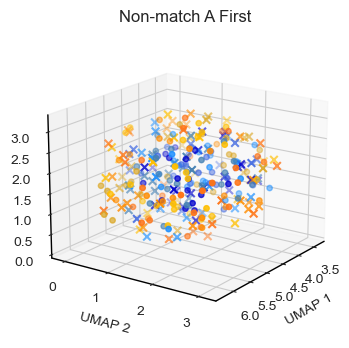

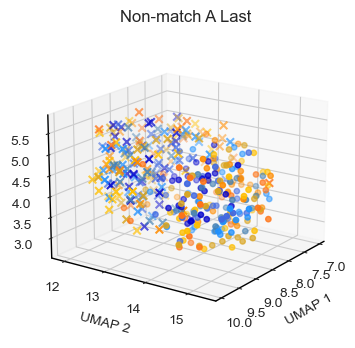

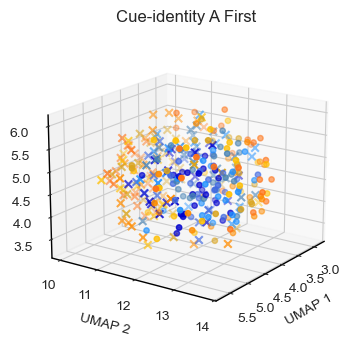

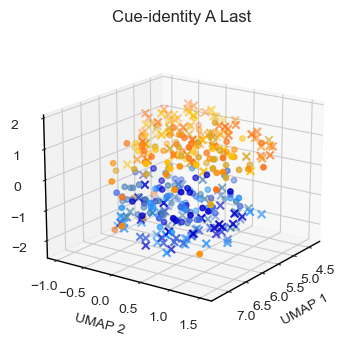

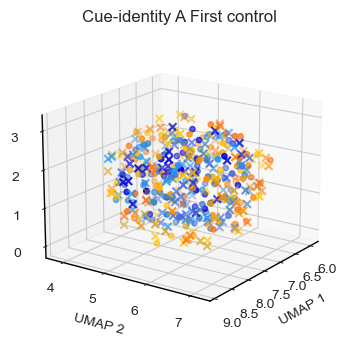

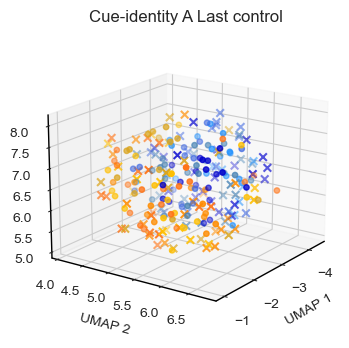

In [4]:
#fig 5 a-c rasters
for i in [0, 4, 15, 19, 25, 29]:
    df_sessions_f = df_sessions.loc[i]
    session_title = df_sessions_f['session_title']

    with open(f"{umap_path}/UMAP_{session_title}.pkl", "rb") as f:
        sd = pickle.load(f)
    X = sd['ALL']['X_umap']
    labels1 = sd['ALL']['plot_meta']['Label'].to_numpy().astype(int)   # 1-based
    labels0 = labels1 - 1
    trial_type = sd['ALL']['plot_meta']['Result']
    #save_to_excel_with_header(X, trial_type, f"{umap_path}/UMAP_data_source.xlsx", "Sheet1", header=f"{session_title}")
    fig, ax = plot_3d(X, labels0, title=f"{session_title}",figsize=(4, 4), elev=18, azim=35, dist=20)


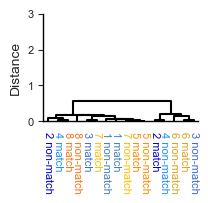

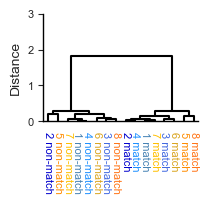

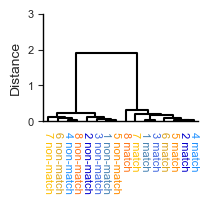

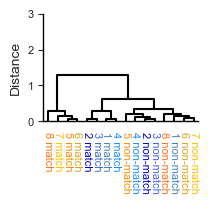

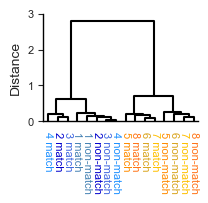

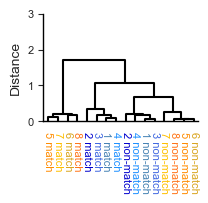

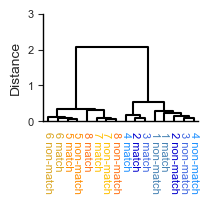

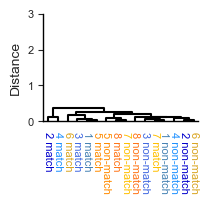

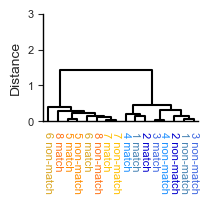

In [34]:
#fig 5 a-c dendrogram
for i in [0,4,9,15,19,20,24,25,29]:
    # for i in  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
    #               25, 26, 27, 28, 29, 30, 31, 32, 33, 34]:
    df_sessions_f=df_sessions.loc[i]
    session_title = df_sessions_f['session_title']

    with open(f"{umap_path}/UMAP_{session_title}.pkl", "rb") as f:
        sd = pickle.load(f)
    L = sd['ALL']['linkage_matrix']
    CM = sd['ALL']['cluster_means']
    fig, ax = plot_dendrogram(L, CM, session_title=session_title,figsize=(2, 1.4))
    ax.set_title(None)
    #ax.set_ylabel(None)
    #ax.set_yticklabels([])

    fig.savefig(f'{fig_path}/5b_{i}.png', dpi=300, bbox_inches="tight")  # PNG, high-res


Non-match A First  p_value_cdnm (median LOSO): 0.06900
Non-match A First  p_value_cue_id (median LOSO): 0.00800
Non-match A Second  p_value_cdnm (median LOSO): 0.01100
Non-match A Second  p_value_cue_id (median LOSO): 0.19200
Non-match A Third  p_value_cdnm (median LOSO): 0.00000
Non-match A Third  p_value_cue_id (median LOSO): 0.02500
Non-match A Forth  p_value_cdnm (median LOSO): 0.00000
Non-match A Forth  p_value_cue_id (median LOSO): 0.54900
Non-match A Last  p_value_cdnm (median LOSO): 0.00000
Non-match A Last  p_value_cue_id (median LOSO): 0.35200
Non-match B First  p_value_cdnm (median LOSO): 0.00000
Non-match B First  p_value_cue_id (median LOSO): 0.32500
Non-match B Second  p_value_cdnm (median LOSO): 0.00000
Non-match B Second  p_value_cue_id (median LOSO): 0.68300
Non-match B Third  p_value_cdnm (median LOSO): 0.00000
Non-match B Third  p_value_cue_id (median LOSO): 0.28700
Non-match B Forth  p_value_cdnm (median LOSO): 0.00000
Non-match B Forth  p_value_cue_id (median LOSO)

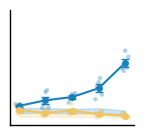

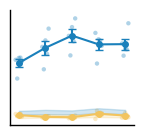

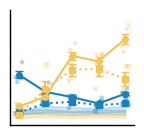

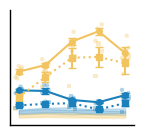

In [21]:
#fig 5 d-e 
data_list=[]
range1 = list(range(0, 10))
range2 = list(range(15, 25))
range3 = list(range(25, 35))
combined_list = range1 + range2 + range3

for i in combined_list:
    df_sessions_f = df_sessions.loc[i]
    session_title = df_sessions_f['session_title']

    with open(f'{umap_path}/UMAP_{session_title}.pkl', 'rb') as f:
        loaded_data = pickle.load(f)

    # --- Aggregate across LOSO dictionary ---
    if 'LOSO' in loaded_data and isinstance(loaded_data['LOSO'], dict):
        folds = [v for v in loaded_data['LOSO'].values() if v.get('valid', True)]

        # per-fold metrics
        m18 = np.array([v.get('mean_1_8', np.nan) for v in folds], dtype=float)
        mc  = np.array([v.get('mean_cue_id', np.nan) for v in folds], dtype=float)

        # store per-fold vectors for plotting raw points later
        loaded_data['folds_m18'] = m18[~np.isnan(m18)].tolist()
        loaded_data['folds_mc']  = mc[~np.isnan(mc)].tolist()

        # permutations pooled across folds
        perm_18_all   = np.concatenate([np.asarray(v.get('perm_mean_1_8', []), dtype=float)
                                        for v in folds if v.get('perm_mean_1_8') is not None]) \
            if any(v.get('perm_mean_1_8') for v in folds) else np.array([])
        perm_cue_all  = np.concatenate([np.asarray(v.get('perm_mean_cue_id', []), dtype=float)
                                        for v in folds if v.get('perm_mean_cue_id') is not None]) \
            if any(v.get('perm_mean_cue_id') for v in folds) else np.array([])

        # LOSO summary
        loaded_data['mean_1_8']        = float(np.nanmean(m18)) if m18.size else np.nan
        loaded_data['loso_sem_1_8']    = _sem(m18)
        loaded_data['mean_cue_id']     = float(np.nanmean(mc))  if mc.size  else np.nan
        loaded_data['loso_sem_cue_id'] = _sem(mc)

        # null bands
        loaded_data['mean_perm']        = float(np.nanmean(perm_18_all)) if perm_18_all.size else np.nan
        loaded_data['std_perm']         = float(np.nanstd(perm_18_all, ddof=1)) if perm_18_all.size > 1 else np.nan
        loaded_data['mean_perm_cueid']  = float(np.nanmean(perm_cue_all)) if perm_cue_all.size else np.nan
        loaded_data['std_perm_cueid']   = float(np.nanstd(perm_cue_all, ddof=1)) if perm_cue_all.size > 1 else np.nan

        # optional p-value aggregation (median)
        pvals_18  = np.array([v.get('p_value_1_8', np.nan) for v in folds], dtype=float)
        pvals_cue = np.array([v.get('p_value_cue_id', np.nan) for v in folds], dtype=float)
        p_value_1_8    = float(np.nanmedian(pvals_18))  if pvals_18.size  else np.nan
        p_value_cue_id = float(np.nanmedian(pvals_cue)) if pvals_cue.size else np.nan
    else:
        p_value_1_8    = loaded_data.get('p_value_1_8', np.nan)
        p_value_cue_id = loaded_data.get('p_value_cue_id', np.nan)
        # keep columns present for plotting
        loaded_data['folds_m18'] = []
        loaded_data['folds_mc']  = []

    loaded_data['session_id'] = i
    data_list.append(loaded_data)

    print(f"{session_title}  p_value_cdnm (median LOSO): {p_value_1_8 if not np.isnan(p_value_1_8) else float('nan'):.5f}")
    print(f"{session_title}  p_value_cue_id (median LOSO): {p_value_cue_id if not np.isnan(p_value_cue_id) else float('nan'):.5f}")

df = pd.DataFrame(data_list)

# ---- plotting (use LOSO SEM for error bars; raw LOSO points in background) ----
color_set = ["#1a80bb", "#f2c45f"]          # cdnm (1-8), cue-id
line_styles = ['-', ':']
Markers = ['o','s']                          # will also use for raw points in second panel
df['bin_column'] = df['session_id'].apply(categorize_into_bins)

import pandas as pd
import matplotlib.pyplot as plt

all_data = []  # list to collect data across bins

for l in [1, 2]:
    group = df[(df.bin_column == l)]
    fig, ax = plt.subplots(figsize=(1.6, 1.5))

    # Raw LOSO fold points (background) for each session
    for x, y_m18, y_mc in zip(group['session_id'], group['folds_m18'], group['folds_mc']):
        _scatter_individual(ax, x, y_m18, marker='o', color=color_set[0], alpha=0.35, size=10)
        _scatter_individual(ax, x, y_mc,  marker='o', color=color_set[1], alpha=0.35, size=10)

        # --- collect the arrays into a flat table ---
        df_temp = pd.DataFrame({
            'session_id': x,
            'y_m18': y_m18,
            'y_mc': y_mc,
            'l': l
        })
        all_data.append(df_temp)

    # mean_1_8 with LOSO SEM
    ax.errorbar(
        group['session_id'], group['mean_1_8'],
        yerr=group['loso_sem_1_8'], capsize=3,
        marker='o', markersize=4, linestyle='-',
        color=color_set[0],
    )

    # mean_cue_id with LOSO SEM
    ax.errorbar(
        group['session_id'], group['mean_cue_id'],
        yerr=group['loso_sem_cue_id'], capsize=3,
        marker='o', markersize=4, linestyle='-',
        color=color_set[1],
    )

    # permutation shading
    ax.fill_between(
        group['session_id'],
        group['mean_perm'] - group['std_perm'],
        group['mean_perm'] + group['std_perm'],
        color=color_set[0], alpha=0.2
    )
    ax.fill_between(
        group['session_id'],
        group['mean_perm_cueid'] - group['std_perm_cueid'],
        group['mean_perm_cueid'] + group['std_perm_cueid'],
        color=color_set[1], alpha=0.2
    )

    ax.set_xticks([]); ax.set_yticks([]); ax.set_ylim([0, 3])
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    #plt.savefig(f'{fig_path}/5c_{l}.png', dpi=300, bbox_inches="tight")

# # ---- Combine and save to Excel ----
# df_all_points = pd.concat(all_data, ignore_index=True)
# df_all_points.to_excel(f'{fig_path}/folds_data_all.xlsx', index=False)


all_rows = []  # collect across l = 4,5

for l in [4, 5]:
    data = df[((df.bin_column == l) | (df.bin_column == l + 2))].copy()

    # Align control sessions (>=30) back to 15–24 range as before
    data['session_id'] = data['session_id'].apply(lambda x: x - 10 if x >= 25 else x)

    # Add group labels per row based on bin_column
    data['group'] = np.where(data['bin_column'] == l, 'Exp', 'Control')

    groups = data.groupby('bin_column', sort=True)
    fig, ax = plt.subplots(figsize=(1.6, 1.5))

    # ---------- collect arrays ONCE (avoid double-appending) ----------
    # Unnest LOSO arrays for both metrics into long rows
    for _, g in groups:
        for sid, y_m18, y_mc, grp in zip(g['session_id'], g['folds_m18'], g['folds_mc'], g['group']):
            # y_m18 and y_mc are arrays/lists of LOSO folds
            df_tmp = pd.DataFrame({
                'session_id': sid,
                'y_m18': y_m18,      # expands down rows
                'y_mc': y_mc,        # expands down rows
            })
            df_tmp['l'] = l
            df_tmp['group'] = grp          # 'Exp' or 'Control'
            df_tmp['bin_column'] = g['bin_column'].iloc[0]  # keep original bin too (l or l+3)
            all_rows.append(df_tmp)

    # ----------------------- plotting: cdnm (1-8) -----------------------
    for idx, (bin_label, group) in enumerate(groups):
        # raw LOSO fold points
        for x, ys in zip(group['session_id'], group['folds_m18']):
            _scatter_individual(ax, x, ys, marker=Markers[idx], color=color_set[0], alpha=0.35, size=10)

        ax.errorbar(
            group['session_id'], group['mean_1_8'],
            yerr=group['loso_sem_1_8'], capsize=3,
            marker=Markers[idx], markersize=4,
            linestyle=line_styles[idx], color=color_set[0],
        )
        ax.fill_between(
            group['session_id'],
            group['mean_perm'] - group['std_perm'],
            group['mean_perm'] + group['std_perm'],
            color=color_set[0], alpha=0.2
        )

    # ----------------------- plotting: cue-id ---------------------------
    for idx, (bin_label, group) in enumerate(groups):
        for x, ys in zip(group['session_id'], group['folds_mc']):
            _scatter_individual(ax, x, ys, marker=Markers[idx], color=color_set[1], alpha=0.35, size=10)

        ax.errorbar(
            group['session_id'], group['mean_cue_id'],
            yerr=group['loso_sem_cue_id'], capsize=3,
            marker=Markers[idx], markersize=4,
            linestyle=line_styles[idx], color=color_set[1],
        )
        ax.fill_between(
            group['session_id'],
            group['mean_perm_cueid'] - group['std_perm_cueid'],
            group['mean_perm_cueid'] + group['std_perm_cueid'],
            color=color_set[1], alpha=0.2
        )

    ax.set_xticks([]); ax.set_yticks([]); ax.set_ylim([0, 3])
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    #plt.savefig(f'{fig_path}/5c_{l}.png', dpi=300, bbox_inches="tight")

# # -------- Save everything to ONE Excel sheet --------
# df_folds_all = pd.concat(all_rows, ignore_index=True)
# # Columns: session_id | y_m18 | y_mc | l | group | bin_column
# df_folds_all.to_excel(f'{fig_path}/folds_data_bins_4_5.xlsx', index=False)


for i in combined_list:
    df_sessions_f = df_sessions.loc[i]
    session_title = df_sessions_f['session_title']

    with open(f'{umap_path}/UMAP_{session_title}.pkl', 'rb') as f:
        sdata = pickle.load(f)

    # LOSO is a dict: {excluded_rat: metrics_dict}
    loso_dict = sdata.get('LOSO', {})
    if not isinstance(loso_dict, dict) or len(loso_dict) == 0:
        raise ValueError(f"Session {session_title} has empty/missing LOSO dict.")

    vals = list(loso_dict.values())

    # Pull per-rat LOSO metrics (names per your schema)
    loso_mean_18   = [v.get('mean_1_8', np.nan)          for v in vals]
    loso_sem_18    = [v.get('sem_1_8', np.nan)           for v in vals]            # not used for averaging, but kept if needed
    loso_mean_cue  = [v.get('mean_cue_id', np.nan)       for v in vals]
    loso_sem_cue   = [v.get('mean_cue_id_sem', np.nan)   for v in vals]            # not used for averaging, but kept if needed

    # Average across rats (LOSO folds); report SEM across rats
    mean_1_8       = float(np.nanmean(loso_mean_18))
    sem_1_8        = float(_nansem(loso_mean_18))
    mean_cue_id    = float(np.nanmean(loso_mean_cue))
    sem_cue_id     = float(_nansem(loso_mean_cue))

    # Pool permutation nulls across rats by concatenation
    perm_18_list   = [np.asarray(v.get('perm_mean_1_8', []), float)     for v in vals]
    perm_cue_list  = [np.asarray(v.get('perm_mean_cue_id', []), float)  for v in vals]
    perm_mean_1_8  = np.concatenate([p[np.isfinite(p)] for p in perm_18_list if p is not None and p.size > 0]) \
        if len(perm_18_list) > 0 else np.array([])
    perm_mean_cue  = np.concatenate([p[np.isfinite(p)] for p in perm_cue_list if p is not None and p.size > 0]) \
        if len(perm_cue_list) > 0 else np.array([])

    # Map session index to group/problem
    if 15 <= i < 25:
        group = 'exp';  problem_idx = i - 15
    elif 25 <= i < 35:
        group = 'ctrl'; problem_idx = i - 25
    else:
        group = 'other'; problem_idx = np.nan

    data_rows.append({
        'session_id': i,
        'session_title': session_title,
        'group': group,
        'problem_idx': problem_idx,

        'mean_1_8':    mean_1_8,
        'sem_1_8':     sem_1_8,
        'mean_cue_id': mean_cue_id,
        'sem_cue_id':  sem_cue_id,

        'perm_mean_1_8':  perm_mean_1_8,
        'perm_mean_cue':  perm_mean_cue,
    })

df = pd.DataFrame(data_rows)

# Pair exp/ctrl per problem
pairable = df[df['group'].isin(['exp','ctrl']) & df['problem_idx'].notna()].copy()
pairs = (pairable
         .pivot_table(index='problem_idx', columns='group',
                      values=['mean_1_8','sem_1_8','mean_cue_id','sem_cue_id',
                              'perm_mean_1_8','perm_mean_cue'],
                      aggfunc='first')
         .dropna(subset=[('mean_1_8','exp'), ('mean_1_8','ctrl')], how='any'))

# Build Δ, Δ-null and p-values
rows = []
for prob_idx, row in pairs.iterrows():
    d_obs_18  = row[('mean_1_8','exp')]    - row[('mean_1_8','ctrl')]
    d_obs_cue = row[('mean_cue_id','exp')] - row[('mean_cue_id','ctrl')]

    delta_null_18  = _pair_delta_null(row[('perm_mean_1_8','exp')],
                                      row[('perm_mean_1_8','ctrl')], B=5000)
    delta_null_cue = _pair_delta_null(row[('perm_mean_cue','exp')],
                                      row[('perm_mean_cue','ctrl')], B=5000)

    p18  = _p_two_sided(d_obs_18,  delta_null_18)
    pcue = _p_two_sided(d_obs_cue, delta_null_cue)

    rows.append({
        'problem_idx': prob_idx,
        'delta_obs_1_8':  d_obs_18,
        'p_delta_1_8':    p18,
        'delta_obs_cue':  d_obs_cue,
        'p_delta_cue':    pcue,
        'delta_null_1_8':  delta_null_18,   # keep if you want to plot nulls
        'delta_null_cue':  delta_null_cue,
        'ctrl_mean_1_8': row[('mean_1_8','ctrl')],
        'ctrl_sem_1_8':  row[('sem_1_8','ctrl')],
        'exp_mean_1_8':  row[('mean_1_8','exp')],
        'exp_sem_1_8':   row[('sem_1_8','exp')],
        'ctrl_mean_cue': row[('mean_cue_id','ctrl')],
        'ctrl_sem_cue':  row[('sem_cue_id','ctrl')],
        'exp_mean_cue':  row[('mean_cue_id','exp')],
        'exp_sem_cue':   row[('sem_cue_id','exp')],
    })

df_diff = pd.DataFrame(rows)

from statsmodels.stats.multitest import multipletests

# Correct only non-match p-values
pvals_18 = df_diff['p_delta_1_8'].values
rej_18, pvals_corr_18, _, _ = multipletests(pvals_18, alpha=0.05, method='holm')
p_delta_cue = df_diff['p_delta_cue'].values
rej_cue, pvals_corr_cue, _, _ = multipletests(p_delta_cue, alpha=0.05, method='holm')

df_diff['p_delta_1_8_corr'] = pvals_corr_18
df_diff['p_delta_cue_corr'] = pvals_corr_cue

#Comparissoon of each group against null

from statsmodels.stats.multitest import multipletests

def _p_two_sided(obs, null):
    null = np.asarray(null, float)
    null = null[np.isfinite(null)]
    if not np.isfinite(obs) or null.size == 0:
        return np.nan
    return float(np.mean(np.abs(null) >= np.abs(obs)))

def _nansem(x, axis=0):
    x = np.asarray(x, float)
    n = np.sum(np.isfinite(x), axis=axis)
    sd = np.nanstd(x, axis=axis, ddof=1)
    with np.errstate(invalid='ignore', divide='ignore'):
        return sd / np.sqrt(n)

rows = []

for i in combined_list:
    df_sessions_f = df_sessions.loc[i]
    session_title = df_sessions_f['session_title']

    with open(f'{umap_path}/UMAP_{session_title}.pkl', 'rb') as f:
        sdata = pickle.load(f)

    loso = sdata.get('LOSO', {})
    if not isinstance(loso, dict) or not loso:
        raise ValueError(f"Missing/empty LOSO for {session_title}")

    vals = list(loso.values())

    # Observed means per rat (LOSO fold)
    means_18  = [v.get('mean_1_8', np.nan)         for v in vals]
    means_cue = [v.get('mean_cue_id', np.nan)      for v in vals]

    # Session-level observed (average across rats); report SEM across rats
    mean_1_8       = float(np.nanmean(means_18))
    sem_1_8        = float(_nansem(means_18))
    mean_cue_id    = float(np.nanmean(means_cue))
    sem_cue_id     = float(_nansem(means_cue))

    # Pool permutation nulls across rats
    perm_18_list  = [np.asarray(v.get('perm_mean_1_8', []), float)    for v in vals]
    perm_cue_list = [np.asarray(v.get('perm_mean_cue_id', []), float) for v in vals]
    perm_1_8      = np.concatenate([p[np.isfinite(p)] for p in perm_18_list  if p is not None and p.size > 0]) \
        if len(perm_18_list)  > 0 else np.array([])
    perm_cue      = np.concatenate([p[np.isfinite(p)] for p in perm_cue_list if p is not None and p.size > 0]) \
        if len(perm_cue_list) > 0 else np.array([])

    # Two-sided permutation p-values per session
    p_1_8  = _p_two_sided(mean_1_8,  perm_1_8)
    p_cue  = _p_two_sided(mean_cue_id, perm_cue)

    # Optional: tag group/problem if useful later
    if 15 <= i < 25:
        group = 'exp';  problem_idx = i - 15
    elif 25 <= i < 35:
        group = 'ctrl'; problem_idx = i - 25
    else:
        group = 'other'; problem_idx = np.nan

    rows.append({
        'session_id': i,
        'session_title': session_title,
        'group': group,
        'problem_idx': problem_idx,
        'mean_1_8': mean_1_8, 'sem_1_8': sem_1_8, 'p_1_8': p_1_8,
        'mean_cue_id': mean_cue_id, 'sem_cue_id': sem_cue_id, 'p_cue': p_cue,
        # keep null sizes for sanity checks
        'n_perm_1_8': int(np.size(perm_1_8)),
        'n_perm_cue': int(np.size(perm_cue)),
    })

df_sess = pd.DataFrame(rows)

# Collect all p-values together
pvals_all = np.concatenate([df_sess['p_1_8'].values, df_sess['p_cue'].values])

# Run Holm correction across the combined set
_, pvals_corr_all, _, _ = multipletests(pvals_all, alpha=0.05, method='holm')

# Split corrected values back into their respective columns
n = len(df_sess)
df_sess['p_1_8_corr'] = pvals_corr_all[:n]
df_sess['p_cue_corr'] = pvals_corr_all[n:]
# Select relevant columns for reporting
report_table = df_sess[['session_id', 'session_title', 'p_1_8_corr', 'p_cue_corr']].copy()

# Round values for readability
report_table[['p_1_8_corr', 'p_cue_corr']] = report_table[['p_1_8_corr', 'p_cue_corr']].round(4)

# Rename columns for clarity
report_table = report_table.rename(columns={
    'session_id': 'Session Index',
    'session_title': 'Stage',
    'p_1_8_corr': 'Non-match p (corr)',
    'p_cue_corr': 'Cue-id p (corr)'
})
print(report_table)



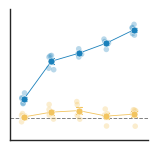

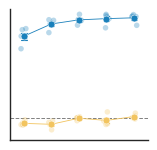

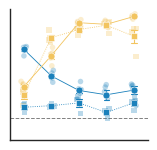

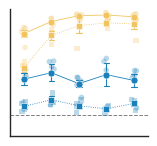

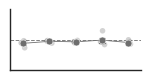

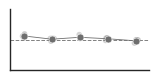

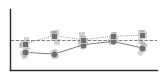

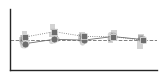

In [13]:
# Fig. 5 f-i
loso_long = prepare_ccgp_loso_long_generic(
    geom_path=geom_path, exp_range=(1,10), include_ctrl=False, bin_size=5, measures=("NM","CI")
)
plot_ccgp_binned_generic(
    loso_long, fig_path=fig_path, measures=("NM","CI"), include_ctrl=False,
    colors={'NM':'#1a80bb','CI':'#f2c45f'},
    ylim=(0.4, 1), ref_y=0.5, fig_width = 2.8,fig_height = 2)

loso_long = prepare_ccgp_loso_long_generic(
    geom_path=geom_path, exp_range=(11,20), include_ctrl=True, ctrl_range=(21,30),
    bin_size=5, measures=("NM","CI")
)
plot_ccgp_binned_generic(
    loso_long, fig_path=fig_path,
    measures=("NM","CI"), include_ctrl=True,
    colors={'NM':"#1a80bb",'CI':"#f2c45f"},  # override both at once
    ylim=(0.4, 1), ref_y=0.5, fig_width = 2.8,fig_height = 2
)
# 

# # Axis cosine, Exp vs Ctrl, ref line at 0.0, tiny fixed size
loso_long = prepare_ccgp_loso_long_generic(
    geom_path=geom_path, exp_range=(1,10), include_ctrl=False,
    bin_size=5, measures="NM vs CI (axis cos)"
)
plot_ccgp_binned_generic(
    loso_long, fig_path=fig_path, measures="NM vs CI (axis cos)", include_ctrl=False,
    colors={'NM vs CI (axis cos)':'#6e6e6e'},
    ylim=(-.2, .2), ref_y=0, fig_width = 3.5,fig_height = 1.3
)
# # Axis cosine, Exp vs Ctrl, ref line at 0.0, tiny fixed size
loso_long = prepare_ccgp_loso_long_generic(
    geom_path=geom_path, exp_range=(11,20), include_ctrl=True, ctrl_range=(21,30),
    bin_size=5, measures="NM vs CI (axis cos)"
)
plot_ccgp_binned_generic(
    loso_long, fig_path=fig_path, measures="NM vs CI (axis cos)", include_ctrl=True,
    colors={'NM vs CI (axis cos)':'#6e6e6e'},
    ylim=(-.2, .2), ref_y=0, fig_width = 3.5,fig_height = 1.3
)

In [29]:
# --- deps
import re
import numpy as np
import pandas as pd
from pathlib import Path
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multitest import multipletests

# SciPy is optional; we’ll use fallbacks if it’s missing
try:
    from scipy.stats import combine_pvalues, t as tdist
    HAVE_SCIPY = True
except Exception:
    HAVE_SCIPY = False

# --- constants
ORDER_MAP = {"First": 1, "Second": 2, "Third": 3, "Forth": 4, "Fourth": 4, "Last": 5}
MEASURES = {
    "CCGP (NM rule)": "NM (CCGP)",              # Panel A
    "CCGP (CI rule)": "CI (CCGP)",              # Panel A
    "Axis cosine (NM↔CI)": "NM vs CI (axis cos)"# Panel C
}

# --- helpers
def is_nm_phase(level: str) -> bool:
    return re.search(r"Non[- ]?match", str(level), flags=re.IGNORECASE) is not None

def extract_block(level: str) -> str:
    m = re.search(r"\b([AB])\b", str(level))
    return m.group(1) if m else np.nan

def extract_order_num(level: str) -> float:
    for k, v in ORDER_MAP.items():
        if re.search(rf"\b{k}\b", str(level), flags=re.IGNORECASE):
            return v
    return np.nan

def nm_session_index(level: str) -> float:
    """
    Map 'Non-match A First'..'Non-match B Last' -> 1..10  (A: +0, B: +5)
    """
    order = extract_order_num(level)
    block = extract_block(level)
    if pd.isna(order) or pd.isna(block):
        return np.nan
    offset = 0 if block.upper() == "A" else 5
    return int(offset + order)

def one_way_anova(df: pd.DataFrame, dv_col="ccgp_mean", factor="session_num") -> dict:
    """
    One-way ANOVA with Partial η² for dv_col ~ Session (10 levels).
    """
    data = df.copy()
    data[factor] = data[factor].astype("category")
    model = ols(f"{dv_col} ~ C({factor})", data=data).fit()
    aov = anova_lm(model, typ=2)

    ss_eff = aov.loc[f"C({factor})", "sum_sq"]
    df_eff = int(aov.loc[f"C({factor})", "df"])
    ss_err = aov.loc["Residual", "sum_sq"]
    df_err = int(aov.loc["Residual", "df"])
    F = float(aov.loc[f"C({factor})", "F"])
    p = float(aov.loc[f"C({factor})", "PR(>F)"])
    eta_p2 = ss_eff / (ss_eff + ss_err) if (ss_eff + ss_err) > 0 else np.nan

    return {"Effect": "Session", "df": f"{df_eff},{df_err}", "F": F, "p-value": p, "Partial η²": eta_p2}

def _normal_2tailed_from_t(tval, df):
    # very conservative normal approximation if SciPy missing
    from math import erf, sqrt
    z = abs(tval)
    # two-tailed p from normal
    return 2 * (1 - 0.5 * (1 + erf(z / sqrt(2))))

def combine_pvals(pvals):
    """
    Combine fold-level permutation p-values by Fisher and Stouffer.
    Falls back to geometric-mean approximation if SciPy isn't available.
    """
    pvals = [float(p) for p in pvals if pd.notna(p) and 0 <= float(p) <= 1]
    if len(pvals) == 0:
        return np.nan, np.nan

    if HAVE_SCIPY:
        # Fisher & Stouffer (equal weights)
        _, p_fisher   = combine_pvalues(pvals, method="fisher")
        _, p_stouffer = combine_pvalues(pvals, method="stouffer")
    else:
        # conservative fallback using geometric mean
        gm = np.exp(np.mean(np.log(np.maximum(np.array(pvals), 1e-300))))
        p_fisher = gm
        p_stouffer = gm
    return float(p_fisher), float(p_stouffer)

def panels_A_C_stats(data_or_path, out_dir=None, quiet=False):
    """
    Notebook entry point for Panels A & C.

    Input:
        data_or_path : DataFrame OR CSV path containing at least:
            ['rule_slice','level','ccgp_mean'] and for permutation aggregation:
            ['p_value'] (fold-level perm p for CCGP rows)
    Behavior:
        - Filters to Experimental-only NM sessions (10 levels)
        - Runs one-way ANOVA per measure (Panels A & C)
        - Aggregates per-session permutation p-values (Fisher, Stouffer) for CCGP rows
        - Adds BH–FDR across sessions per rule to Fisher p's

    Returns:
        anova_tbl : DataFrame  (summary ANOVA table for Panels A & C)
        perm_tbl  : DataFrame  (aggregated per-session permutation results)
    """
    # --- load
    if isinstance(data_or_path, (str, Path)):
        df = pd.read_csv(data_or_path)
    elif isinstance(data_or_path, pd.DataFrame):
        df = data_or_path.copy()
    else:
        raise TypeError("data_or_path must be a DataFrame or a CSV path.")

    # --- basic checks
    needed = {"rule_slice", "level", "ccgp_mean"}
    missing = needed - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {sorted(missing)}")

    # Experimental only and NM phase only
    # (Assumes control rows contain 'control' in 'level')
    df = df[~df["level"].str.contains("control", case=False, na=False)].copy()
    df = df[df["level"].apply(is_nm_phase)].copy()

    # Session number 1..10
    df["session_num"] = df["level"].apply(nm_session_index)
    if df["session_num"].isna().any():
        missing_levels = df[df["session_num"].isna()]["level"].unique()
        raise ValueError(f"Couldn't parse session index for: {missing_levels}")

    # Keep only measures of interest
    df = df[df["rule_slice"].isin(MEASURES.values())].copy()

    # ---------- ONE-WAY ANOVAs (Panels A & C) ----------
    rows = []
    for label, key in MEASURES.items():
        sub = df[df["rule_slice"] == key].copy()
        if sub.empty:
            continue
        res = one_way_anova(sub, dv_col="ccgp_mean", factor="session_num")
        row = {"Panel": ("A" if "CCGP" in label else "C"), "Measure": label}
        row.update(res)
        rows.append(row)

    if not rows:
        raise RuntimeError("No ANOVA rows created; check filtering and columns.")
    anova_tbl = pd.DataFrame(rows)

    # ---------- PER-SESSION PERMUTATION AGGREGATION (Panels A only) ----------
    perm_rows = []
    if "p_value" in df.columns:
        for label, key in MEASURES.items():
            if "CCGP" not in label:
                continue  # typically we have perm p for CCGP, not for cosine
            sub = df[df["rule_slice"] == key].copy()
            for snum, g in sub.groupby("session_num"):
                pvals = list(g["p_value"].dropna().astype(float))
                p_fisher, p_stouffer = combine_pvals(pvals)

                vals = g["ccgp_mean"].dropna().astype(float).values
                n = len(vals)
                if n >= 2:
                    mean = float(np.mean(vals))
                    sd   = float(np.std(vals, ddof=1))
                    if sd > 0:
                        t = (mean - 0.5) / (sd / np.sqrt(n))
                        if HAVE_SCIPY:
                            p_t = 2 * (1 - tdist.cdf(abs(t), df=n-1))
                        else:
                            p_t = _normal_2tailed_from_t(t, df=n-1)
                    else:
                        t, p_t = np.inf, 0.0
                else:
                    mean, t, p_t = (float(np.mean(vals)) if n > 0 else np.nan), np.nan, np.nan

                perm_rows.append({
                    "Rule": label,
                    "Session": int(snum),
                    "n_folds": int(n),
                    "mean": mean,
                    "p_combined_fisher": p_fisher,
                    "p_combined_stouffer": p_stouffer,
                    "t_one_sample_vs_0.5": t,
                    "p_t_one_sample": p_t
                })

    perm_tbl = pd.DataFrame(perm_rows) if perm_rows else pd.DataFrame(
        columns=["Rule","Session","n_folds","mean","p_combined_fisher",
                 "p_combined_stouffer","t_one_sample_vs_0.5","p_t_one_sample"]
    )

    if not perm_tbl.empty:
        # BH–FDR across sessions within each rule using Fisher-combined p
        perm_tbl["q_BH_FDR"] = np.nan
        for rule, grp in perm_tbl.groupby("Rule"):
            mask = np.isfinite(grp["p_combined_fisher"].values)
            if mask.sum() > 0:
                _, qvals, _, _ = multipletests(grp["p_combined_fisher"].values[mask], method="fdr_bh")
                perm_tbl.loc[grp.index[mask], "q_BH_FDR"] = qvals

        # nice ordering
        perm_tbl = perm_tbl.sort_values(["Rule", "Session"]).reset_index(drop=True)

    # ---------- optional save ----------
    if out_dir is not None:
        out_dir = Path(out_dir)
        out_dir.mkdir(parents=True, exist_ok=True)
        anova_path = out_dir / "oneway_A_C_anova.csv"
        perm_path  = out_dir / "per_session_perm_agg.csv"
        anova_tbl.to_csv(anova_path, index=False)
        perm_tbl.to_csv(perm_path, index=False)

        if not quiet:
            print(f"Saved: {anova_path}")
            print(f"Saved: {perm_path}")

    if not quiet:
        print("\n=== ONE-WAY ANOVAs (Panels A & C; Experimental NM sessions only) ===")
        print(anova_tbl.to_string(index=False))
        if not perm_tbl.empty:
            print("\n=== Aggregated permutation (per session; Panels A rules) ===")
            cols = ["Rule","Session","n_folds","mean","p_combined_fisher",
                    "p_combined_stouffer","t_one_sample_vs_0.5","p_t_one_sample","q_BH_FDR"]
            print(perm_tbl[cols].to_string(index=False))

    return anova_tbl, perm_tbl


In [30]:
in_csv  = "/Users/maori2/Documents/revision_stuff/All_dataset/geom_files/ccgp_pseudopop_LOSO_all_levels.csv"
out_dir = "/Users/maori2/Documents/revision_stuff/All_dataset/geom_files"
anova_tbl, perm_tbl = panels_A_C_stats(in_csv, out_dir=out_dir, quiet=False)


Saved: /Users/maori2/Documents/revision_stuff/All_dataset/geom_files/oneway_A_C_anova.csv
Saved: /Users/maori2/Documents/revision_stuff/All_dataset/geom_files/per_session_perm_agg.csv

=== ONE-WAY ANOVAs (Panels A & C; Experimental NM sessions only) ===
Panel             Measure  Effect   df          F      p-value  Partial η²
    A      CCGP (NM rule) Session 9,40 122.429933 3.061040e-26    0.964970
    A      CCGP (CI rule) Session 9,40   4.361593 5.214173e-04    0.495296
    C Axis cosine (NM↔CI) Session 9,40   5.323750 8.869524e-05    0.545009

=== Aggregated permutation (per session; Panels A rules) ===
          Rule  Session  n_folds     mean  p_combined_fisher  p_combined_stouffer  t_one_sample_vs_0.5  p_t_one_sample  q_BH_FDR
CCGP (CI rule)        1        5 0.505846           0.998198             1.000000             0.908154    4.151635e-01  0.999998
CCGP (CI rule)        2        5 0.527910           0.927826             1.000000             2.460230    6.967418e-02  0.9999

/Users/maori2/opt/anaconda3/envs/umap-env/lib/python3.10/site-packages/scipy/stats/_stats_py.py:8980: RuntimeWarning: divide by zero encountered in log
  statistic = -2 * xp.sum(xp.log(pvalues), axis=axis)
/Users/maori2/opt/anaconda3/envs/umap-env/lib/python3.10/site-packages/scipy/stats/_stats_py.py:8980: RuntimeWarning: divide by zero encountered in log
  statistic = -2 * xp.sum(xp.log(pvalues), axis=axis)
/Users/maori2/opt/anaconda3/envs/umap-env/lib/python3.10/site-packages/scipy/stats/_stats_py.py:8980: RuntimeWarning: divide by zero encountered in log
  statistic = -2 * xp.sum(xp.log(pvalues), axis=axis)
/Users/maori2/opt/anaconda3/envs/umap-env/lib/python3.10/site-packages/scipy/stats/_stats_py.py:8980: RuntimeWarning: divide by zero encountered in log
  statistic = -2 * xp.sum(xp.log(pvalues), axis=axis)
/Users/maori2/opt/anaconda3/envs/umap-env/lib/python3.10/site-packages/scipy/stats/_stats_py.py:8980: RuntimeWarning: divide by zero encountered in log
  statistic = -2 * xp.su

In [39]:
# === ONE CELL: Panels A–D ANOVA + Permutation aggregation (Panel B now 10 CI sessions) ===
import re
import numpy as np
import pandas as pd
from pathlib import Path
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multitest import fdrcorrection

try:
    from scipy.stats import combine_pvalues, t as tdist
    HAVE_SCIPY = True
except Exception:
    HAVE_SCIPY = False

# -------------------- parsing helpers --------------------
ORDER_MAP = {"First": 1, "Second": 2, "Third": 3, "Forth": 4, "Fourth": 4, "Last": 5}
MEASURES_DICT = {
    "CCGP (NM rule)": "NM (CCGP)",
    "CCGP (CI rule)": "CI (CCGP)",
    "Axis cosine (NM↔CI)": "NM vs CI (axis cos)",
}

def is_nm_phase(level: str) -> bool:
    return re.search(r"Non[- ]?match", str(level), flags=re.IGNORECASE) is not None

def is_ci_phase(level: str) -> bool:
    return re.search(r"Cue[- ]?identity", str(level), flags=re.IGNORECASE) is not None

def extract_block(level: str):
    m = re.search(r"\b([AB])\b", str(level))
    return m.group(1) if m else np.nan

def extract_order_num(level: str):
    for k, v in ORDER_MAP.items():
        if re.search(rf"\b{k}\b", str(level), flags=re.IGNORECASE):
            return v
    return np.nan

def session_index(level: str, phase: str):
    """
    Map 'Non-match|Cue-identity  A|B  First..Last' -> 1..10
    A: +0 (1..5), B: +5 (6..10)
    """
    if phase == "NM" and not is_nm_phase(level): return np.nan
    if phase == "CI" and not is_ci_phase(level): return np.nan
    order = extract_order_num(level)
    block = extract_block(level)
    if pd.isna(order) or pd.isna(block): return np.nan
    return int((0 if str(block).upper() == "A" else 5) + order)

# -------------------- ANOVA helpers --------------------
def one_way_anova(df: pd.DataFrame, dv_col="ccgp_mean", factor="session_num"):
    data = df.copy()
    data[factor] = data[factor].astype("category")
    model = ols(f"{dv_col} ~ C({factor})", data=data).fit()
    aov = anova_lm(model, typ=2)
    ss_eff = float(aov.loc[f"C({factor})", "sum_sq"])
    df_eff = int(aov.loc[f"C({factor})", "df"])
    ss_err = float(aov.loc["Residual", "sum_sq"])
    df_err = int(aov.loc["Residual", "df"])
    F = float(aov.loc[f"C({factor})", "F"])
    p = float(aov.loc[f"C({factor})", "PR(>F)"])
    eta_p2 = ss_eff / (ss_eff + ss_err) if (ss_eff + ss_err) > 0 else np.nan
    return {"Effect": "Session", "df": f"{df_eff},{df_err}", "F": F, "p_value": p, "Partial η²": eta_p2}

def two_way_anova_group_level(df: pd.DataFrame, dv_col="ccgp_mean"):
    """
    Type-II Group × Level (order_num 1..5) with partial η².
    """
    data = df.copy()
    data["group"] = data["group"].astype("category")
    data["order_num"] = data["order_num"].astype("category")
    model = ols(f"{dv_col} ~ C(group) * C(order_num)", data=data).fit()
    aov = anova_lm(model, typ=2)
    if "Residual" not in aov.index:
        raise ValueError("ANOVA table missing Residual row; check inputs.")
    ss_err = float(aov.loc["Residual", "sum_sq"])
    df_err = int(aov.loc["Residual", "df"])
    rows = []
    for effect in ["C(group)", "C(order_num)", "C(group):C(order_num)"]:
        if effect in aov.index:
            ss = float(aov.loc[effect, "sum_sq"])
            df_eff = int(aov.loc[effect, "df"])
            F = float(aov.loc[effect, "F"])
            p = float(aov.loc[effect, "PR(>F)"])
            petasq = ss / (ss + ss_err) if (ss + ss_err) > 0 else np.nan
            rows.append({
                "Effect": effect.replace("C(", "").replace(")", "").replace(":", " × "),
                "df": f"{df_eff},{df_err}",
                "F": F,
                "p_value": p,
                "Partial η²": petasq
            })
    return pd.DataFrame(rows)

# -------------------- permutation helpers --------------------
def combine_pvals(pvals):
    """Fisher & Stouffer; robust if SciPy missing (falls back to geometric mean)."""
    pvals = [float(p) for p in pvals if pd.notna(p) and 0.0 <= float(p) <= 1.0]
    if len(pvals) == 0:
        return np.nan, np.nan
    if HAVE_SCIPY:
        _, p_fisher   = combine_pvalues(pvals, method="fisher")
        _, p_stouffer = combine_pvalues(pvals, method="stouffer")
    else:
        gm = np.exp(np.mean(np.log(np.maximum(np.array(pvals), 1e-300))))
        p_fisher = gm
        p_stouffer = gm
    return float(p_fisher), float(p_stouffer)

def ttest_vs_point5(vals):
    vals = np.asarray(vals, dtype=float)
    vals = vals[~np.isnan(vals)]
    n = len(vals)
    if n < 2:
        return n, (float(np.mean(vals)) if n else np.nan), np.nan, np.nan
    mean = float(np.mean(vals))
    sd = float(np.std(vals, ddof=1))
    if sd == 0:
        return n, mean, np.inf, 0.0
    t = (mean - 0.5) / (sd / np.sqrt(n))
    if HAVE_SCIPY:
        p = 2 * (1 - tdist.cdf(abs(t), df=n-1))
    else:
        from math import erf, sqrt
        p = 2 * (1 - 0.5 * (1 + erf(abs(t)/sqrt(2))))
    return n, mean, float(t), float(p)

def fdr_within(df, key_cols, p_col="p_combined_fisher", q_col="q_BH_FDR", sig_col="significant_FDR", alpha=0.05):
    """BH–FDR within each natural family (see calls below)."""
    df[q_col] = np.nan
    df[sig_col] = False
    if df.empty or p_col not in df.columns: return df
    for keys, g in df.groupby(key_cols):
        vals = g[p_col].astype(float).values
        mask = np.isfinite(vals)
        if mask.any():
            _, q = fdrcorrection(vals[mask], alpha=alpha, method="indep")
            idx = g.index[mask]
            df.loc[idx, q_col] = q
            df.loc[idx, sig_col] = q < alpha
    return df

# -------------------- main runner --------------------
def run_all_panels(data_or_path, out_dir=None, quiet=False):
    """
    Returns:
      anova_all_panels : DataFrame (Panels A–D)
      perm_all_panels  : DataFrame (Panels A–D) with within-family BH–FDR:
                         - A/C: per Rule across 10 NM sessions (Experimental)
                         - B/D: per Rule × Group across 10 CI sessions (Experimental & Control)
    """
    # Load
    if isinstance(data_or_path, (str, Path)):
        df = pd.read_csv(data_or_path)
    elif isinstance(data_or_path, pd.DataFrame):
        df = data_or_path.copy()
    else:
        raise TypeError("data_or_path must be a DataFrame or a CSV path.")

    need = {"rule_slice", "level", "ccgp_mean"}
    miss = need - set(df.columns)
    if miss:
        raise ValueError(f"Missing required columns: {sorted(miss)}")

    # Normalize
    df = df[df["rule_slice"].isin(MEASURES_DICT.values())].copy()
    df["group"] = np.where(df["level"].str.contains("control", case=False, na=False), "Control", "Experimental")
    df["is_nm"] = df["level"].apply(is_nm_phase)
    df["is_ci"] = df["level"].apply(is_ci_phase)
    df["order_num"] = df["level"].apply(extract_order_num)
    df["session_num_nm"] = df["level"].apply(lambda s: session_index(s, "NM"))
    df["session_num_ci"] = df["level"].apply(lambda s: session_index(s, "CI"))

    # ---------------- ANOVAs ----------------
    anova_rows = []

    # A & C: one-way over 10 NM sessions (Experimental only)
    df_nm_exp = df[(df["group"] == "Experimental") & (df["is_nm"])].copy()
    if df_nm_exp["session_num_nm"].isna().any():
        bad = df_nm_exp[df_nm_exp["session_num_nm"].isna()]["level"].unique()
        raise ValueError(f"Could not parse NM session index for: {bad}")

    for meas_label in ["CCGP (NM rule)", "CCGP (CI rule)"]:
        key = MEASURES_DICT[meas_label]
        sub = df_nm_exp[df_nm_exp["rule_slice"] == key].copy()
        if not sub.empty:
            res = one_way_anova(sub.rename(columns={"session_num_nm":"session_num"}), dv_col="ccgp_mean", factor="session_num")
            res.update({"Panel": "A", "Measure": meas_label})
            anova_rows.append(res)

    meas_label = "Axis cosine (NM↔CI)"
    key = MEASURES_DICT[meas_label]
    sub = df_nm_exp[df_nm_exp["rule_slice"] == key].copy()
    if not sub.empty:
        res = one_way_anova(sub.rename(columns={"session_num_nm":"session_num"}), dv_col="ccgp_mean", factor="session_num")
        res.update({"Panel": "C", "Measure": meas_label})
        anova_rows.append(res)

    # B & D: Group × Level (order 1..5) in CI (ANOVA stays on 5 levels, as in figs)
    df_ci = df[df["is_ci"] & df["order_num"].notna()].copy()
    if "excluded_rat" not in df_ci.columns:
        df_ci["excluded_rat"] = np.arange(len(df_ci))
    group_cols = ["group", "order_num", "excluded_rat", "rule_slice"]
    df_ci_collapsed = df_ci.groupby(group_cols, as_index=False)["ccgp_mean"].mean()

    for meas_label in ["CCGP (NM rule)", "CCGP (CI rule)"]:
        key = MEASURES_DICT[meas_label]
        sub = df_ci_collapsed[df_ci_collapsed["rule_slice"] == key].copy()
        if not sub.empty:
            aov_tbl = two_way_anova_group_level(sub, dv_col="ccgp_mean")
            aov_tbl.insert(0, "Measure", meas_label)
            aov_tbl.insert(0, "Panel", "B")
            anova_rows.append(aov_tbl)

    meas_label = "Axis cosine (NM↔CI)"
    key = MEASURES_DICT[meas_label]
    sub = df_ci_collapsed[df_ci_collapsed["rule_slice"] == key].copy()
    if not sub.empty:
        aov_tbl = two_way_anova_group_level(sub, dv_col="ccgp_mean")
        aov_tbl.insert(0, "Measure", meas_label)
        aov_tbl.insert(0, "Panel", "D")
        anova_rows.append(aov_tbl)

    # Stack ANOVAs
    anova_frames = []
    for r in anova_rows:
        anova_frames.append(pd.DataFrame([r]) if isinstance(r, dict) else r)
    anova_all_panels = pd.concat(anova_frames, ignore_index=True)
    anova_all_panels = anova_all_panels[["Panel","Measure","Effect","df","F","p_value","Partial η²"]]

    # ---------------- Permutation aggregation ----------------
    perm_rows = []
    has_perm_p = "p_value" in df.columns

    # Panel A: Experimental NM sessions 1..10 (two rules)
    for meas_label in ["CCGP (NM rule)", "CCGP (CI rule)"]:
        key = MEASURES_DICT[meas_label]
        sub = df_nm_exp[df_nm_exp["rule_slice"] == key].copy()
        for snum, g in sub.groupby("session_num_nm"):
            p_fisher, p_stouffer = (np.nan, np.nan)
            if has_perm_p: p_fisher, p_stouffer = combine_pvals(g["p_value"])
            n, mean, t, p_t = ttest_vs_point5(g["ccgp_mean"])
            perm_rows.append({
                "Panel": "A", "Group": "Experimental", "Rule": meas_label,
                "Session": int(snum), "n_folds": int(n), "mean": mean,
                "p_combined_fisher": p_fisher, "p_combined_stouffer": p_stouffer,
                "t_one_sample_vs_0.5": t, "p_t_one_sample": p_t
            })

    # Panel C: Experimental NM sessions 1..10 (axis cosine)
    meas_label = "Axis cosine (NM↔CI)"
    key = MEASURES_DICT[meas_label]
    sub = df_nm_exp[df_nm_exp["rule_slice"] == key].copy()
    for snum, g in sub.groupby("session_num_nm"):
        p_fisher, p_stouffer = (np.nan, np.nan)
        if has_perm_p: p_fisher, p_stouffer = combine_pvals(g["p_value"])
        n, mean, t, p_t = ttest_vs_point5(g["ccgp_mean"])
        perm_rows.append({
            "Panel": "C", "Group": "Experimental", "Rule": meas_label,
            "Session": int(snum), "n_folds": int(n), "mean": mean,
            "p_combined_fisher": p_fisher, "p_combined_stouffer": p_stouffer,
            "t_one_sample_vs_0.5": t, "p_t_one_sample": p_t
        })

    # Panels B & D: CI sessions 1..10 (A/B×First..Last), split by Group
    df_ci_sessions = df[df["is_ci"] & df["session_num_ci"].notna()].copy()  # <- 10-session granularity
    for panel_label, measures in [("B", ["CCGP (NM rule)", "CCGP (CI rule)"]),
                                  ("D", ["Axis cosine (NM↔CI)"])]:
        for meas_label in measures:
            key = MEASURES_DICT[meas_label]
            sub = df_ci_sessions[df_ci_sessions["rule_slice"] == key].copy()
            for (grp, snum), g in sub.groupby(["group", "session_num_ci"]):
                p_fisher, p_stouffer = (np.nan, np.nan)
                if has_perm_p: p_fisher, p_stouffer = combine_pvals(g["p_value"])
                n, mean, t, p_t = ttest_vs_point5(g["ccgp_mean"])
                perm_rows.append({
                    "Panel": panel_label, "Group": grp, "Rule": meas_label,
                    "Session": int(snum),  # 1..10 CI sessions
                    "n_folds": int(n), "mean": mean,
                    "p_combined_fisher": p_fisher, "p_combined_stouffer": p_stouffer,
                    "t_one_sample_vs_0.5": t, "p_t_one_sample": p_t
                })

    perm_all_panels = pd.DataFrame(perm_rows, columns=[
        "Panel","Group","Rule","Session","n_folds","mean",
        "p_combined_fisher","p_combined_stouffer","t_one_sample_vs_0.5","p_t_one_sample"
    ]).sort_values(["Panel","Group","Rule","Session"]).reset_index(drop=True)

    # ---- Within-family BH–FDR on p_combined_fisher ----
    # A/C: per Rule across 10 NM sessions (Experimental only)
    mask_ac = perm_all_panels["Panel"].isin(["A","C"])
    perm_all_panels.loc[mask_ac, ["q_BH_FDR","significant_FDR"]] = np.nan
    perm_all_panels = fdr_within(
        perm_all_panels, key_cols=["Panel","Rule"],  # Experimental only (A/C)
        p_col="p_combined_fisher", q_col="q_BH_FDR", sig_col="significant_FDR", alpha=0.05
    )
    # B/D: per Rule × Group across 10 CI sessions
    perm_all_panels = fdr_within(
        perm_all_panels, key_cols=["Panel","Rule","Group"],
        p_col="p_combined_fisher", q_col="q_BH_FDR", sig_col="significant_FDR", alpha=0.05
    )

    # ---------------- save / print ----------------
    if out_dir is not None:
        out = Path(out_dir); out.mkdir(parents=True, exist_ok=True)
        anova_path = out / "ANOVA_panels_A_B_C_D.csv"
        perm_path  = out / "Permutation_agg_panels_A_B_C_D_FDR.csv"
        anova_all_panels.to_csv(anova_path, index=False)
        perm_all_panels.to_csv(perm_path, index=False)
        if not quiet:
            print(f"Saved: {anova_path}")
            print(f"Saved: {perm_path}")

    if not quiet:
        def fmt(df_):
            df_ = df_.copy()
            for col in ["F","p_value","Partial η²","mean","p_combined_fisher",
                        "p_combined_stouffer","t_one_sample_vs_0.5","p_t_one_sample","q_BH_FDR"]:
                if col in df_.columns:
                    df_[col] = df_[col].apply(lambda x: f"{x:.3e}" if isinstance(x, float) and (abs(x) < 1e-3 or abs(x) >= 1e3)
                    else (f"{x:.3f}" if isinstance(x, float) else x))
            return df_
        print("\n=== ANOVA (Panels A–D) ===")
        print(fmt(anova_all_panels).to_string(index=False))
        print("\n=== Permutation (Panels A–D) with within-family BH–FDR ===")
        show = ["Panel","Group","Rule","Session","n_folds","mean","p_combined_fisher","q_BH_FDR","significant_FDR"]
        print(fmt(perm_all_panels[show]).to_string(index=False))

    return anova_all_panels, perm_all_panels


In [40]:
in_csv  = "/Users/maori2/Documents/revision_stuff/All_dataset/geom_files/ccgp_pseudopop_LOSO_all_levels.csv"
out_dir = "/Users/maori2/Documents/revision_stuff/All_dataset/geom_files"
anova_df, perm_df = run_all_panels(in_csv,
                                   out_dir=out_dir,
                                   quiet=False)


Saved: /Users/maori2/Documents/revision_stuff/All_dataset/geom_files/ANOVA_panels_A_B_C_D.csv
Saved: /Users/maori2/Documents/revision_stuff/All_dataset/geom_files/Permutation_agg_panels_A_B_C_D_FDR.csv

=== ANOVA (Panels A–D) ===
Panel             Measure            Effect   df       F   p_value Partial η²
    A      CCGP (NM rule)           Session 9,40 122.430 3.061e-26      0.965
    A      CCGP (CI rule)           Session 9,40   4.362 5.214e-04      0.495
    C Axis cosine (NM↔CI)           Session 9,40   5.324 8.870e-05      0.545
    B      CCGP (NM rule)             group 1,77 109.618 1.850e-16      0.587
    B      CCGP (NM rule)         order_num 4,77   4.103     0.005      0.176
    B      CCGP (NM rule) group × order_num 4,77   3.432     0.012      0.151
    B      CCGP (CI rule)             group 1,77  10.349     0.002      0.118
    B      CCGP (CI rule)         order_num 4,77  39.997 4.307e-18      0.675
    B      CCGP (CI rule) group × order_num 4,77   1.862     0.126  

/Users/maori2/opt/anaconda3/envs/umap-env/lib/python3.10/site-packages/scipy/stats/_stats_py.py:8980: RuntimeWarning: divide by zero encountered in log
  statistic = -2 * xp.sum(xp.log(pvalues), axis=axis)
/Users/maori2/opt/anaconda3/envs/umap-env/lib/python3.10/site-packages/scipy/stats/_stats_py.py:8980: RuntimeWarning: divide by zero encountered in log
  statistic = -2 * xp.sum(xp.log(pvalues), axis=axis)
/Users/maori2/opt/anaconda3/envs/umap-env/lib/python3.10/site-packages/scipy/stats/_stats_py.py:8980: RuntimeWarning: divide by zero encountered in log
  statistic = -2 * xp.sum(xp.log(pvalues), axis=axis)


In [17]:
# --- deps
import re
import numpy as np
import pandas as pd
from pathlib import Path
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# --- constants (same as script)
ORDER_MAP = {"First": 1, "Second": 2, "Third": 3, "Forth": 4, "Fourth": 4, "Last": 5}
MEASURES = [
    ("CCGP (NM rule)", "NM (CCGP)"),
    ("CCGP (CI rule)", "CI (CCGP)"),
    ("Axis cosine (NM↔CI)", "NM vs CI (axis cos)"),
]
PANEL_MAP = {
    "CCGP (NM rule)": "B",          # Panel B
    "CCGP (CI rule)": "B",
    "Axis cosine (NM↔CI)": "D",     # Panel D
}

# --- helpers
def phase_from_level(level: str) -> str:
    if re.search(r"Cue[- ]?identity", str(level), flags=re.IGNORECASE):
        return "CI"
    if re.search(r"Non[- ]?match", str(level), flags=re.IGNORECASE):
        return "NM"
    return "Unknown"

def extract_order_num(level: str) -> float:
    for k, v in ORDER_MAP.items():
        if re.search(rf"\b{k}\b", str(level), flags=re.IGNORECASE):
            return v
    return np.nan

def anova_simple(df: pd.DataFrame, dv_col="ccgp_mean", factorA="group", factorB="order_num") -> pd.DataFrame:
    """
    Type-II two-way ANOVA (Group × Level) with partial eta^2.
    Expects factorA and factorB as categorical columns.
    """
    data = df.copy()
    data[factorA] = data[factorA].astype("category")
    data[factorB] = data[factorB].astype("category")

    model = ols(f"{dv_col} ~ C({factorA}) * C({factorB})", data=data).fit()
    aov = anova_lm(model, typ=2)
    ss_err = aov.loc["Residual", "sum_sq"]
    df_err = int(aov.loc["Residual", "df"])

    rows = []
    for effect in ["C(group)", "C(order_num)", "C(group):C(order_num)"]:
        if effect in aov.index:
            ss = aov.loc[effect, "sum_sq"]
            df_eff = int(aov.loc[effect, "df"])
            fval = float(aov.loc[effect, "F"])
            pval = float(aov.loc[effect, "PR(>F)"])
            petasq = ss / (ss + ss_err) if (ss + ss_err) > 0 else np.nan
            rows.append({
                "Effect": effect.replace("C(", "").replace(")", "").replace(":", " × "),
                "df": f"{df_eff},{df_err}",
                "F": fval,
                "p_value": pval,
                "Partial η²": petasq,
            })
    return pd.DataFrame(rows)

def ccgp_group_level_anovas(data_or_path, out_dir=None, quiet=False):
    """
    Notebook entry point.
    Parameters
    ----------
    data_or_path : (pd.DataFrame or str/Path)
        Either a DataFrame with columns:
            ['rule_slice','level','excluded_rat','ccgp_mean', ...]
        or a CSV path containing those columns.
    out_dir : str/Path or None
        If provided, saves:
            - ccgp_angle_ANOVA_group_by_level_simple.csv
            - Fig_B_D_ANOVA_table.csv
    quiet : bool
        If False (default), prints a pretty summary like the script.

    Returns
    -------
    anova_all : pd.DataFrame
        Raw ANOVA table (all measures, effects).
    fig_tbl : pd.DataFrame
        Figure-style summary table (Panel, Measure, Effect, df, F, p_value, Partial η²).
    """
    # --- load
    if isinstance(data_or_path, (str, Path)):
        df = pd.read_csv(data_or_path)
    elif isinstance(data_or_path, pd.DataFrame):
        df = data_or_path.copy()
    else:
        raise TypeError("data_or_path must be a DataFrame or a CSV path.")

    required = {"rule_slice", "level", "excluded_rat", "ccgp_mean"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {sorted(missing)}")

    # keep relevant measures
    keep = [m[1] for m in MEASURES]
    df = df[df["rule_slice"].isin(keep)].copy()

    # group label from level (Control vs Experimental)
    df["group"] = np.where(df["level"].str.contains("control", case=False), "Control", "Experimental")

    # CI phase only (align controls to CI phase)
    df["phase"] = df["level"].apply(phase_from_level)
    df = df[df["phase"] == "CI"].copy()

    # Level order (First..Last -> 1..5); ignore A/B after averaging
    df["order_num"] = df["level"].apply(extract_order_num)

    # collapse A/B within each level per rat (average)
    group_cols = ["group", "order_num", "excluded_rat", "rule_slice"]
    collapsed = df.groupby(group_cols, as_index=False)["ccgp_mean"].mean()

    # run ANOVAs per measure
    results = []
    for label, key in MEASURES:
        sub = collapsed[collapsed["rule_slice"] == key].copy()
        if sub.empty:
            continue
        aov_tbl = anova_simple(sub)
        aov_tbl.insert(0, "Measure", label)
        results.append(aov_tbl)

    if not results:
        raise RuntimeError("No ANOVA results produced (check filters and column values).")

    anova_all = pd.concat(results, ignore_index=True)

    # figure-style table
    fig_tbl = anova_all.copy()
    fig_tbl.insert(0, "Panel", fig_tbl["Measure"].map(PANEL_MAP))
    fig_tbl = fig_tbl[["Panel", "Measure", "Effect", "df", "F", "p_value", "Partial η²"]]

    # save if requested
    if out_dir is not None:
        out_path = Path(out_dir)
        out_path.mkdir(parents=True, exist_ok=True)
        (out_path / "ccgp_angle_ANOVA_group_by_level_simple.csv").write_text(anova_all.to_csv(index=False))
        (out_path / "Fig_B_D_ANOVA_table.csv").write_text(fig_tbl.to_csv(index=False))

    if not quiet:
        def fmt(x):
            if isinstance(x, float):
                if x != 0 and (abs(x) < 1e-3 or abs(x) >= 1e3):
                    return f"{x:.3e}"
                return f"{x:.3f}"
            return x
        disp = fig_tbl.copy()
        disp["F"] = disp["F"].map(fmt)
        disp["p_value"] = disp["p_value"].map(fmt)
        disp["Partial η²"] = disp["Partial η²"].map(fmt)
        print("\n=== Figure-style ANOVA (Panels B & D; CI-phase only) ===")
        print(disp.to_string(index=False))

    return anova_all, fig_tbl


In [18]:
in_csv  = "/Users/maori2/Documents/revision_stuff/All_dataset/geom_files/ccgp_pseudopop_LOSO_all_levels.csv"
out_dir = "/Users/maori2/Documents/revision_stuff/All_dataset/geom_files"
anova_all, fig_tbl = ccgp_group_level_anovas(in_csv, out_dir=out_dir)



=== Figure-style ANOVA (Panels B & D; CI-phase only) ===
Panel             Measure            Effect   df       F   p_value Partial η²
    B      CCGP (NM rule)             group 1,77 109.618 1.850e-16      0.587
    B      CCGP (NM rule)         order_num 4,77   4.103     0.005      0.176
    B      CCGP (NM rule) group × order_num 4,77   3.432     0.012      0.151
    B      CCGP (CI rule)             group 1,77  10.349     0.002      0.118
    B      CCGP (CI rule)         order_num 4,77  39.997 4.307e-18      0.675
    B      CCGP (CI rule) group × order_num 4,77   1.862     0.126      0.088
    D Axis cosine (NM↔CI)             group 1,77  42.945 5.755e-09      0.358
    D Axis cosine (NM↔CI)         order_num 4,77   4.325     0.003      0.183
    D Axis cosine (NM↔CI) group × order_num 4,77   2.676     0.038      0.122


In [113]:
def set_view(ax, elev=None, azim=None, dist=None, lim=None):
    if elev is not None or azim is not None:
        ax.view_init(elev=elev if elev is not None else ax.elev,
                     azim=azim  if azim  is not None else ax.azim)
    if dist is not None:
        try: ax.dist = dist
        except Exception: pass
    if lim is not None:
        (x0,x1),(y0,y1),(z0,z1) = lim
        ax.set_xlim(x0,x1); ax.set_ylim(y0,y1); ax.set_zlim(z0,z1)
    ax.figure.canvas.draw_idle()




In [17]:
import numpy as np
import pandas as pd
import pickle
from statsmodels.stats.multitest import multipletests

def _pair_delta_null(exp_perm, ctrl_perm, B=5000, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    a = np.asarray(exp_perm, float); a = a[np.isfinite(a)]
    b = np.asarray(ctrl_perm, float); b = b[np.isfinite(b)]
    if a.size == 0 or b.size == 0:
        return np.array([])
    if a.size == b.size and B is None:
        return b - a
    if B is None:
        B = min(a.size, b.size)
    ia = rng.integers(0, a.size, size=B)
    ib = rng.integers(0, b.size, size=B)
    return b[ib] - a[ia]

def _p_two_sided(delta_obs, delta_null):
    if not np.isfinite(delta_obs) or delta_null.size == 0:
        return np.nan
    return float(np.mean(np.abs(delta_null) >= np.abs(delta_obs)))

def _nansem(x, axis=0):
    x = np.asarray(x, float)
    n = np.sum(np.isfinite(x), axis=axis)
    sd = np.nanstd(x, axis=axis, ddof=1)
    with np.errstate(invalid='ignore', divide='ignore'):
        return sd / np.sqrt(n)

data_rows = []
range1 = list(range(0, 10))     # Non-match A then B
range2 = list(range(15, 25))    # Experimental cue-id A then B
range3 = list(range(25, 35))    # Control group
combined_list = range1 + range2 + range3

for i in combined_list:
    df_sessions_f = df_sessions.loc[i]
    session_title = df_sessions_f['session_title']

    with open(f'{umap_path}/UMAP_{session_title}.pkl', 'rb') as f:
        sdata = pickle.load(f)

    # LOSO is a dict: {excluded_rat: metrics_dict}
    loso_dict = sdata.get('LOSO', {})
    if not isinstance(loso_dict, dict) or len(loso_dict) == 0:
        raise ValueError(f"Session {session_title} has empty/missing LOSO dict.")

    vals = list(loso_dict.values())

    # Pull per-rat LOSO metrics (names per your schema)
    loso_mean_18   = [v.get('mean_1_8', np.nan)          for v in vals]
    loso_sem_18    = [v.get('sem_1_8', np.nan)           for v in vals]            # not used for averaging, but kept if needed
    loso_mean_cue  = [v.get('mean_cue_id', np.nan)       for v in vals]
    loso_sem_cue   = [v.get('mean_cue_id_sem', np.nan)   for v in vals]            # not used for averaging, but kept if needed

    # Average across rats (LOSO folds); report SEM across rats
    mean_1_8       = float(np.nanmean(loso_mean_18))
    sem_1_8        = float(_nansem(loso_mean_18))
    mean_cue_id    = float(np.nanmean(loso_mean_cue))
    sem_cue_id     = float(_nansem(loso_mean_cue))

    # Pool permutation nulls across rats by concatenation
    perm_18_list   = [np.asarray(v.get('perm_mean_1_8', []), float)     for v in vals]
    perm_cue_list  = [np.asarray(v.get('perm_mean_cue_id', []), float)  for v in vals]
    perm_mean_1_8  = np.concatenate([p[np.isfinite(p)] for p in perm_18_list if p is not None and p.size > 0]) \
        if len(perm_18_list) > 0 else np.array([])
    perm_mean_cue  = np.concatenate([p[np.isfinite(p)] for p in perm_cue_list if p is not None and p.size > 0]) \
        if len(perm_cue_list) > 0 else np.array([])

    # Map session index to group/problem
    if 15 <= i < 25:
        group = 'exp';  problem_idx = i - 15
    elif 25 <= i < 35:
        group = 'ctrl'; problem_idx = i - 25
    else:
        group = 'other'; problem_idx = np.nan

    data_rows.append({
        'session_id': i,
        'session_title': session_title,
        'group': group,
        'problem_idx': problem_idx,

        'mean_1_8':    mean_1_8,
        'sem_1_8':     sem_1_8,
        'mean_cue_id': mean_cue_id,
        'sem_cue_id':  sem_cue_id,

        'perm_mean_1_8':  perm_mean_1_8,
        'perm_mean_cue':  perm_mean_cue,
    })

df = pd.DataFrame(data_rows)

# Pair exp/ctrl per problem
pairable = df[df['group'].isin(['exp','ctrl']) & df['problem_idx'].notna()].copy()
pairs = (pairable
         .pivot_table(index='problem_idx', columns='group',
                      values=['mean_1_8','sem_1_8','mean_cue_id','sem_cue_id',
                              'perm_mean_1_8','perm_mean_cue'],
                      aggfunc='first')
         .dropna(subset=[('mean_1_8','exp'), ('mean_1_8','ctrl')], how='any'))

# Build Δ, Δ-null and p-values
rows = []
for prob_idx, row in pairs.iterrows():
    d_obs_18  = row[('mean_1_8','exp')]    - row[('mean_1_8','ctrl')]
    d_obs_cue = row[('mean_cue_id','exp')] - row[('mean_cue_id','ctrl')]

    delta_null_18  = _pair_delta_null(row[('perm_mean_1_8','exp')],
                                      row[('perm_mean_1_8','ctrl')], B=5000)
    delta_null_cue = _pair_delta_null(row[('perm_mean_cue','exp')],
                                      row[('perm_mean_cue','ctrl')], B=5000)

    p18  = _p_two_sided(d_obs_18,  delta_null_18)
    pcue = _p_two_sided(d_obs_cue, delta_null_cue)

    rows.append({
        'problem_idx': prob_idx,
        'delta_obs_1_8':  d_obs_18,
        'p_delta_1_8':    p18,
        'delta_obs_cue':  d_obs_cue,
        'p_delta_cue':    pcue,
        'delta_null_1_8':  delta_null_18,   # keep if you want to plot nulls
        'delta_null_cue':  delta_null_cue,
        'ctrl_mean_1_8': row[('mean_1_8','ctrl')],
        'ctrl_sem_1_8':  row[('sem_1_8','ctrl')],
        'exp_mean_1_8':  row[('mean_1_8','exp')],
        'exp_sem_1_8':   row[('sem_1_8','exp')],
        'ctrl_mean_cue': row[('mean_cue_id','ctrl')],
        'ctrl_sem_cue':  row[('sem_cue_id','ctrl')],
        'exp_mean_cue':  row[('mean_cue_id','exp')],
        'exp_sem_cue':   row[('sem_cue_id','exp')],
    })

df_diff = pd.DataFrame(rows)

from statsmodels.stats.multitest import multipletests

# Correct only non-match p-values
pvals_18 = df_diff['p_delta_1_8'].values
rej_18, pvals_corr_18, _, _ = multipletests(pvals_18, alpha=0.05, method='holm')
p_delta_cue = df_diff['p_delta_cue'].values
rej_cue, pvals_corr_cue, _, _ = multipletests(p_delta_cue, alpha=0.05, method='holm')

df_diff['p_delta_1_8_corr'] = pvals_corr_18
df_diff['p_delta_cue_corr'] = pvals_corr_cue

